In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import iminuit as minuit


import scipy

from scipy.signal import find_peaks
from sklearn.linear_model import LinearRegression
from scipy import stats
from scipy import optimize
from scipy.optimize import curve_fit
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.stats import chisquare
from iminuit import cost

In [3]:
### read and calibrate data
def readDS(filename, calibration_file):
    print('File:', filename)
    comments = []
    with open(filename) as ff:
        lines = ff.readlines()
        start = pd.to_datetime(lines[14][6:-1])
        commentlength = int(lines[17][-3:-1])
        print(commentlength, start)
        for i in range(0,commentlength):
            comments.append(lines[19+i][9:-1])
        print(comments)
    
    """ read datafile store as dataframe name temp """
    temp = pd.read_csv(filename, sep = '\t', skiprows = 19+commentlength, header = None,usecols = np.arange(0,8))
    temp.columns = ['name', 'det', 't', 'evt_num', 'x', 'y', 'ychan', 'xchan']
    temp = temp.query('det == "DS"')

    """ look for events where more than one strip was hit"""
    temp['nX'] = temp.groupby(['t', 'xchan'])['t'].transform('count')
    temp['nY'] = temp.groupby(['t', 'ychan'])['t'].transform('count')
    #print ('--------before--------')
    #print (temp)

    #apply the calibration file
    #pull the three columns of the cali file, and merge with temp
    """ convert channel number to energy. Using a linear calibration of E = (m*(chan - b) + 89.2)/1.005  """
    """ The factors of 89.2 and 1.005 are just offsets to account for detector dead layer energy loss """
    temp2 = pd.merge(temp, calibration_file[['x', 'mx', 'xint']], on = 'x', how = 'left')
    temp2 = pd.merge(temp2, calibration_file[['y', 'my', 'yint']], on = 'y', how = 'left')
    temp2['xstripE'] = temp2['mx'] * temp2['xchan'] + temp2['xint']
    temp2['ystripE'] = temp2['my'] * temp2['ychan'] + temp2['yint']
    #print ('--------after calibration is applied')
    #print (temp2)



    """ make a flag to identify differences in strips between higher-multiplicity events """
    temp2['xdiff'] = temp2.groupby(['t'])['x'].transform('max') - temp2.groupby(['t'])['x'].transform('min')
    temp2['ydiff'] = temp2.groupby(['t'])['y'].transform('max') - temp2.groupby(['t'])['y'].transform('min')
    
    """ get energy sums for events """
    temp2['xE']= temp2.groupby(['t','nX'])['xstripE'].transform('sum')/(temp2['nX'])
    temp2['yE'] = temp2.groupby(['t', 'nY'])['ystripE'].transform('sum')/temp2['nY']

    """ query out events with multiplicity > 2 and mult = 2 events which aren't in neighbouring strips"""
    temp3 = temp2.query('xdiff < 2 and ydiff < 2')
    
    """ another flag to keep the lowest energy x,y hit of mult = 2 events """
    temp3 = temp3.sort_values(by = ['t','xchan','ychan'], ascending = [True,False,False])
    temp3['xdup'] = temp3.duplicated(['t','xchan'], keep = 'last')#keep = 'first')
    temp3['ydup'] = temp3.duplicated(['t', 'ychan'], keep = 'last') #keep = 'first')
    temp4 = temp3.query('xdup == False and ydup == False').drop(['ychan','xchan', 'xdiff', 'ydiff', 'xdup','ydup'], axis = 1)
    
    #drop these calibration columns if not greater than 0
    """ choose which columns appear in the sorted dataframe """
    result = temp4.drop(['xstripE', 'ystripE', 'mx', 'xint', 'my', 'yint'], axis = 1).query('xE > 0 and yE > 0')
    
    filedur = max(result['t']) - min(result['t'])
    #print('This file calibrated using Edep = 1.005*Einc - 89.2 keV')
    #print('duration = %is = %.2lf min = %.2lf hr \n -----------------------------------------------------------------'%(filedur, filedur/60, filedur/3600))
    
    """ return the final dataframe and the start time from the header"""

    return result, start


### guassian fit
def fourpeaks(x, amp1,cen1,sigma1, amp2,cen2,sigma2,amp3,cen3,sigma3,amp4,cen4,sigma4):
    return amp1*(np.exp((-1.0/2.0)*(((x-cen1)/sigma1)**2))) + amp2*(np.exp((-1.0/2.0)*(((x-cen2)/sigma2)**2)))+amp3*(np.exp((-1.0/2.0)*(((x-cen3)/sigma3)**2)))+amp4*(np.exp((-1.0/2.0)*(((x-cen4)/sigma4)**2)))




# f037

File: run231_037_output.txt
3 2020-03-25 19:28:37
[' scaled to 201/1 for At calibration for 10 mins', ' stopped gas flow', ' changed BGS magnets to Q1=1344 M1=296 M2=465']


/var/folders/z5/wjs7x0tx3t777dypj187gf_h0000gn/T/ipykernel_89780/1805324934.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['nX'] = temp.groupby(['t', 'xchan'])['t'].transform('count')
/var/folders/z5/wjs7x0tx3t777dypj187gf_h0000gn/T/ipykernel_89780/1805324934.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['nY'] = temp.groupby(['t', 'ychan'])['t'].transform('count')


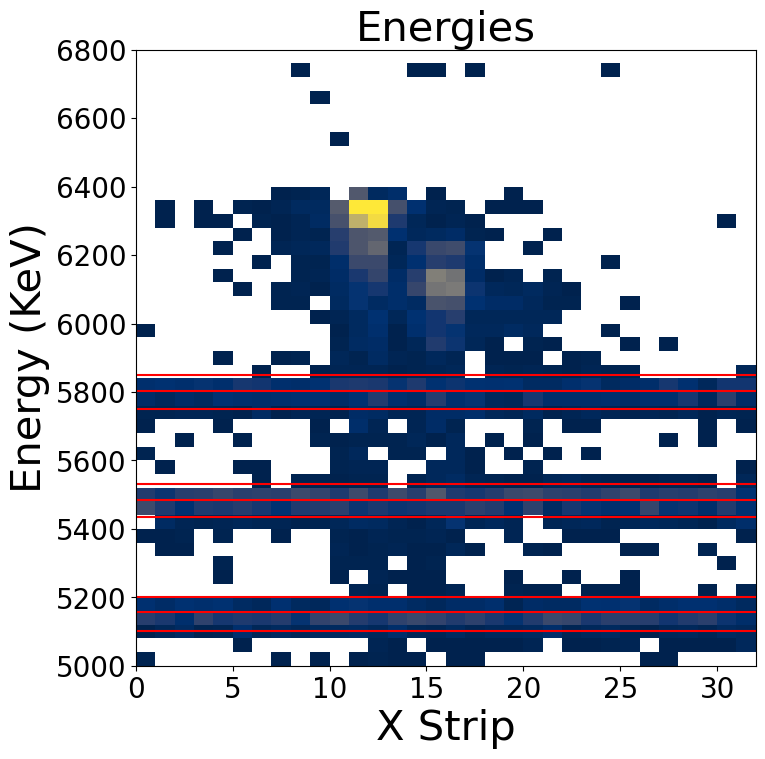

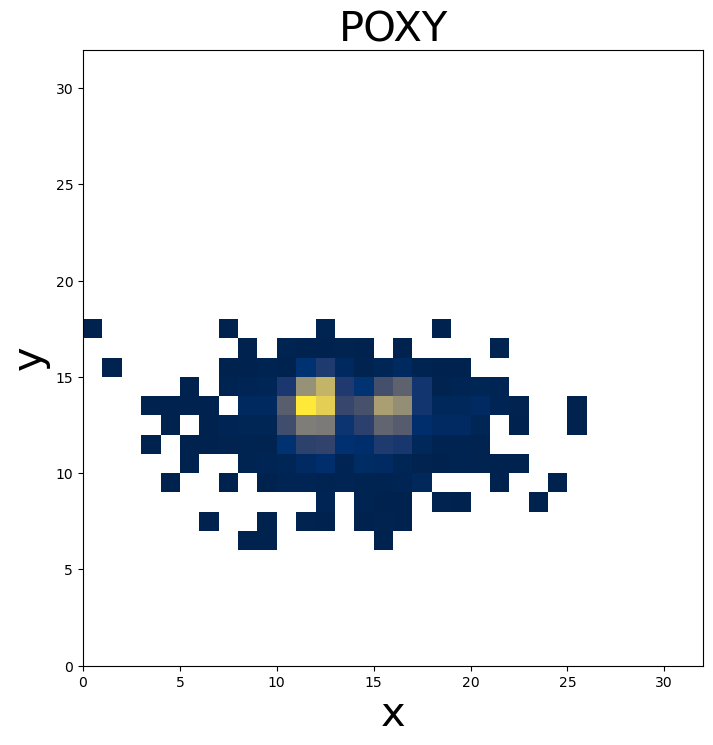

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 28.45 (chi2/ndof = 2.2)    │              Nfcn = 898              │
│ EDM = 1.13e-05 (Goal: 0.0002)    │            time = 0.1 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │       SOME Parameters at limit       │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬────

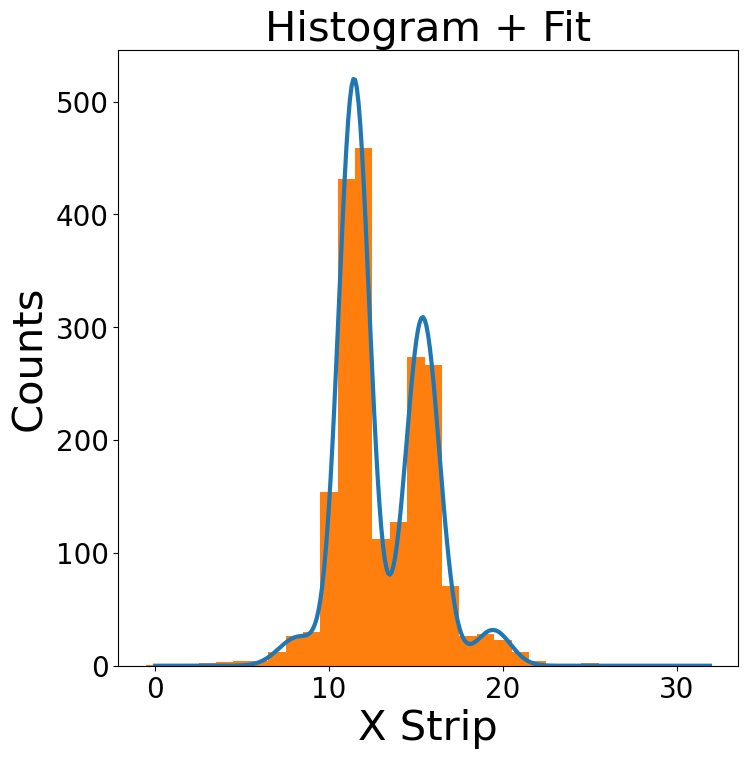

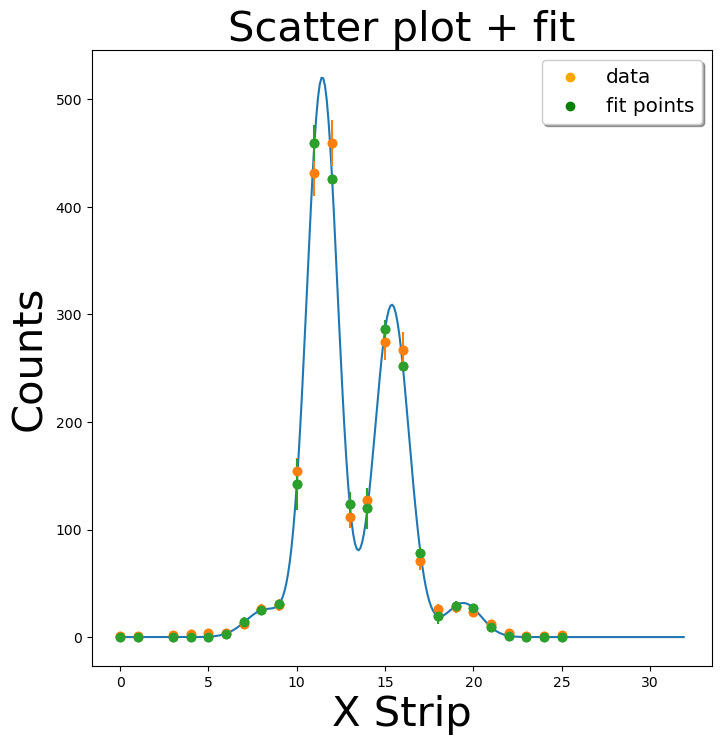

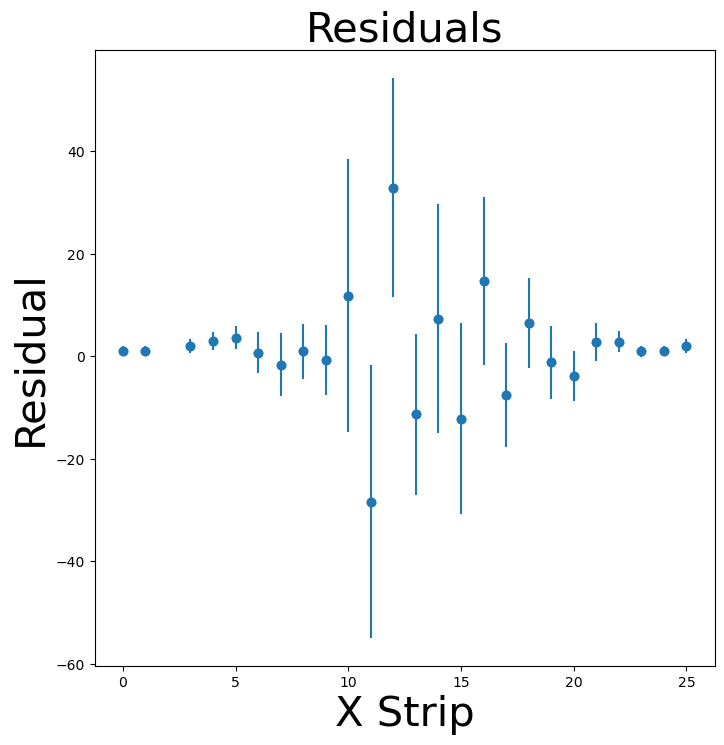

Text(0.5, 1.0, 'Sim Check')

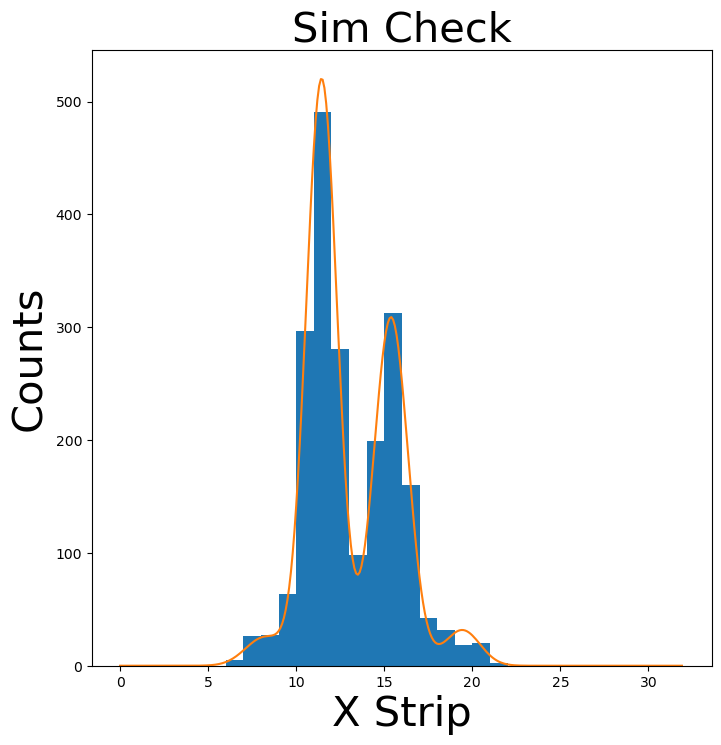

In [4]:
cal = pd.read_csv('run231_calibration_run037.txt', sep = '\t', index_col = 0)

df, t1 = readDS('run231_037_output.txt', cal)

### Checking Energies
plt.figure(figsize = (8,8))
plt.hist2d(df['x'], df['xE'], range = ((0,32),(5000,9000)), bins = (32,100), cmap = 'cividis', cmin = 1)
plt.tick_params(axis='both', labelsize=20)
plt.xlabel('X Strip', fontsize= 30)
plt.ylabel('Energy (KeV)',fontsize = 30)
plt.ylim(5000,6800)
plt.axhline(5156, color = "red")
plt.axhline(5200, color = "red")
plt.axhline(5100, color = "red")
plt.axhline(5485, color = "red")
plt.axhline(5530, color = "red")
plt.axhline(5435, color = "red")
plt.axhline(5804, color = "red")
plt.axhline(5850, color = "red")
plt.axhline(5750, color = "red")
plt.title("Energies", fontsize = 30)
plt.show()


### Gating Data and setting up Histograms
gates = df[(df['y'] >=6) & (df['y'] < 19) & (df['xE'] > 5900) & (df['xE']<6500)]


### POXY
plt.figure(figsize = (8,8))
plt.hist2d(gates['x'], gates['y'], range = ((0,32),(0,32)), bins = (32,32), cmap = 'cividis', cmin = 1)
plt.xlabel('x', fontsize = 30)
plt.ylabel('y', fontsize = 30)
plt.title("POXY", fontsize = 30)
plt.show()

### Creating the histogram and fit
xbins = range(0,32)
counts,bins = np.histogram(gates['x'],bins = xbins)
bins_=np.arange(0,32,.1)
_bins=np.arange(0,32,1)
newBins_change = _bins[np.where(counts != 0)]
newcounts= counts[np.where(counts!=0)]
ye = np.sqrt(newcounts)
c = cost.LeastSquares(newBins_change,newcounts,ye,fourpeaks)
m= minuit.Minuit(c,40,8,1,435,11,1,310,16,1,30,20,1)
m.limits = [(0,None),(None,10),(0,1.1),(0,None), (None,None), (None,None), (0,None ), (None,None), (None, None),(0,None),(None,None),(0, 1)]
print (m.migrad())
amp_1=m.values[0]
cen_1=m.values[1]
exp_1=m.values[2]
amp_2=m.values[3]
cen_2=m.values[4]
exp_2=m.values[5]
amp_3=m.values[6]
cen_3=m.values[7]
exp_3=m.values[8]
amp_4=m.values[9]
cen_4=m.values[10]
exp_4=m.values[11]
yy= fourpeaks(bins_,amp_1,cen_1,exp_1, amp_2,cen_2,exp_2,amp_3,cen_3,exp_3,amp_4,cen_4,exp_4)
yy_=fourpeaks(newBins_change,amp_1,cen_1,exp_1, amp_2,cen_2,exp_2,amp_3,cen_3,exp_3,amp_4,cen_4,exp_4)
plt.figure(figsize = (8,8))
plt.plot(bins_,yy,linewidth=3)
c_= np.sqrt(newcounts)
error = abs((amp_1+m.errors[0])*(1/((exp_1+m.errors[2])))*(np.exp((-1.0/2.0)*(((newBins_change-cen_1+m.errors[1])/(exp_1+m.errors[2]))**2))) +  (m.errors[3]+amp_2)*(1/((m.errors[5]+exp_2)))*(np.exp((-1.0/2.0)*(((newBins_change-cen_2+m.errors[4])/(m.errors[5]+exp_2))**2)))+ (m.errors[6]+amp_3)*(1/((m.errors[8]+exp_3)))*(np.exp((-1.0/2.0)*(((newBins_change-cen_3+m.errors[7])/(m.errors[8]+exp_3))**2)))+(m.errors[9]+amp_4)*(1/((m.errors[11]+exp_4)))*(np.exp((-1.0/2.0)*(((newBins_change-cen_4+m.errors[10])/(m.errors[11]+exp_4))**2)))-((amp_1)*(1/((exp_1)))*(np.exp((-1.0/2.0)*(((newBins_change-cen_1)/(exp_1))**2))) +  (amp_2)*(1/((exp_2)))*(np.exp((-1.0/2.0)*(((newBins_change-cen_2)/(exp_2))**2)))+ (amp_3)*(1/((exp_3)))*(np.exp((-1.0/2.0)*(((newBins_change-cen_3)/(exp_3))**2)))+(amp_4)*(1/((exp_4)))*(np.exp((-1.0/2.0)*(((newBins_change-cen_4)/(exp_4))**2)))))
reserror= np.sqrt(c_**2+error**2)
plt.hist(gates['x'], bins = xbins,align='left')
plt.xlabel('X Strip', fontsize= 30)
plt.ylabel('Counts',fontsize = 30)
plt.tick_params(axis='both', labelsize=20)
plt.title("Histogram + Fit", fontsize = 30)
plt.show()

#### Scatter plot with fit
plt.figure(figsize= (8,8))
plt.plot(bins_,yy)
plt.title("Scatter plot + fit", fontsize = 30)
plt.scatter(newBins_change,newcounts,label='data',color='orange')
plt.errorbar(newBins_change,newcounts,yerr=c_, fmt= "o")
plt.scatter(newBins_change,yy_,label="fit points", color='green')
plt.errorbar(newBins_change,yy_,yerr=error, fmt= 'o')
plt.xlabel('X Strip', fontsize= 30)
plt.ylabel('Counts',fontsize = 30)
legend = plt.legend(loc='upper right', shadow=True, fontsize='x-large')
plt.show()

### Residuals
residual_2lorentz = (newcounts - yy_)
#plt.errorbar(_bins,yy_,yerr=residual_2lorentz, fmt= "o")
#print ( residual_2lorentz)
plt.figure(figsize= (8,8))
plt.title("Residuals", fontsize = 30)
plt.scatter(newBins_change,residual_2lorentz)
plt.errorbar(newBins_change,residual_2lorentz, yerr=reserror, fmt= 'o')
plt.xlabel('X Strip', fontsize= 30)
plt.ylabel('Residual',fontsize = 30)
plt.show()

### Fit Check/ Sim
area1=amp_1*exp_1/.3989
area2=amp_2*exp_2/.3989
area3=amp_3*exp_3/.3989
area4=amp_4*exp_4/.3989
total= area1+area2+area3+area4

area_1=area1/total
area_2=area2/total
area_3=area3/total
area_4=area4/total


plt.figure(figsize = (8,8))


mu = [cen_1,cen_2,cen_3,cen_4]
sigma = [exp_1,exp_2,exp_3,exp_4]
area = [area_1,area_2,area_3,area_4]
n = sum(counts)
x=[]
for i in range (n):
    hi = (np.argmax(np.random.multinomial(1,area)))
    hii= (np.random.normal(mu[hi], sigma[hi]))
    x.append(hii)


countss_,bins,ignored = plt.hist(x,32,range = (0,32), density=False)
bins_=np.arange(0,32,.1)
plt.plot(bins_,yy)
plt.xlabel('X Strip', fontsize= 30)
plt.ylabel('Counts',fontsize = 30)
plt.title("Sim Check", fontsize = 30)


In [10]:
# f040

File: run231_040_output.txt
3 2020-03-26 09:01:45
[' At calibration', ' A/q=202/1', ' no gas added']


/var/folders/z5/wjs7x0tx3t777dypj187gf_h0000gn/T/ipykernel_89780/1805324934.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['nX'] = temp.groupby(['t', 'xchan'])['t'].transform('count')
/var/folders/z5/wjs7x0tx3t777dypj187gf_h0000gn/T/ipykernel_89780/1805324934.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['nY'] = temp.groupby(['t', 'ychan'])['t'].transform('count')


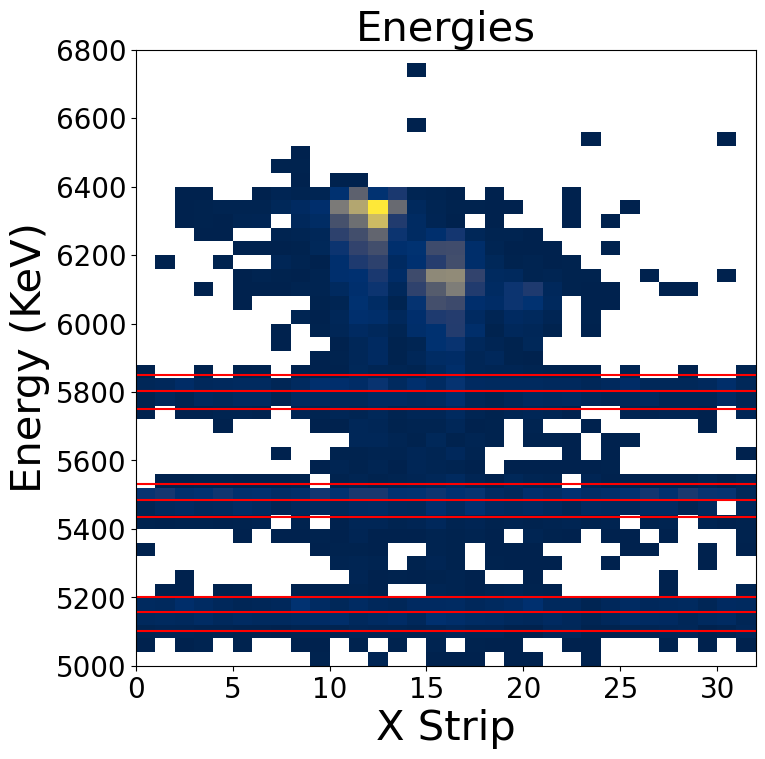

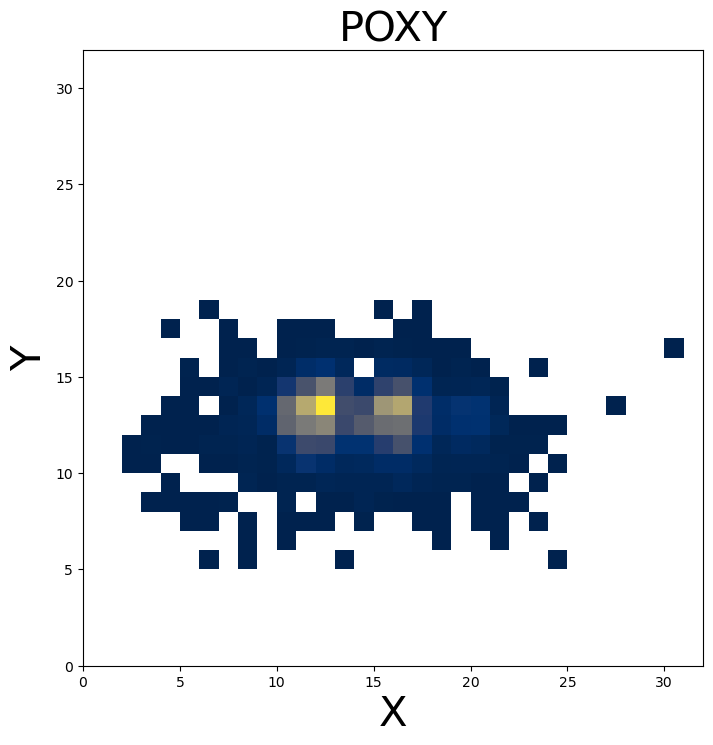

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 92.38 (chi2/ndof = 7.1)    │              Nfcn = 903              │
│ EDM = 0.000104 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │       SOME Parameters at limit       │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬────

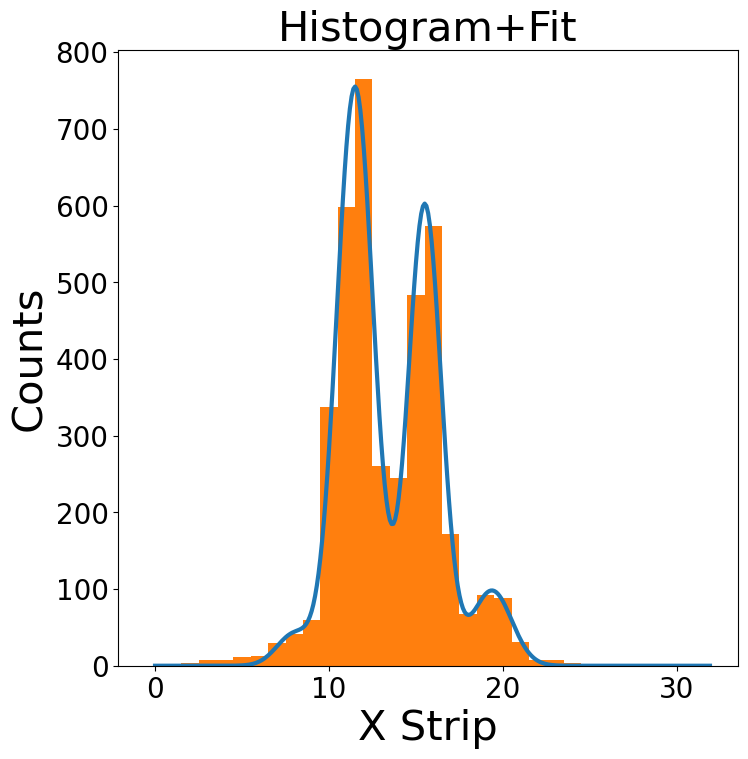

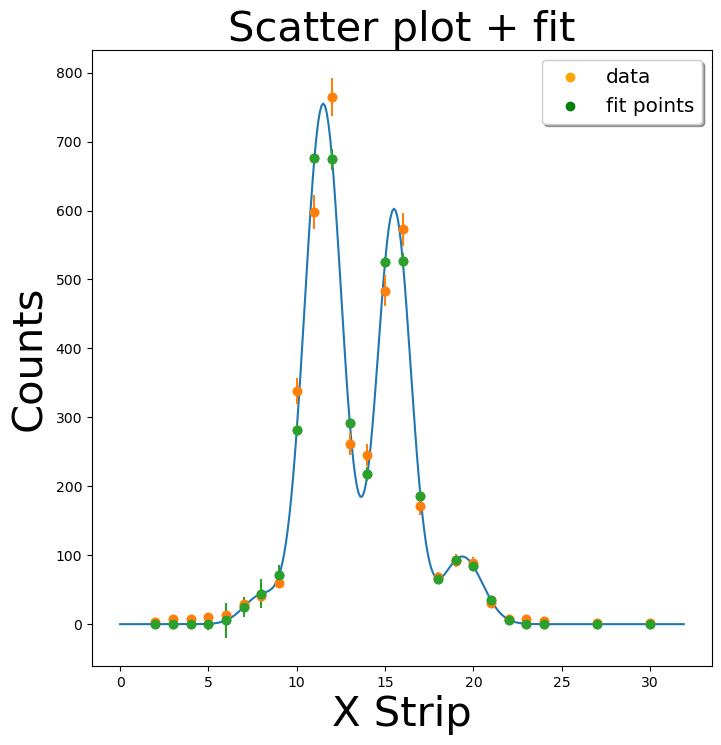

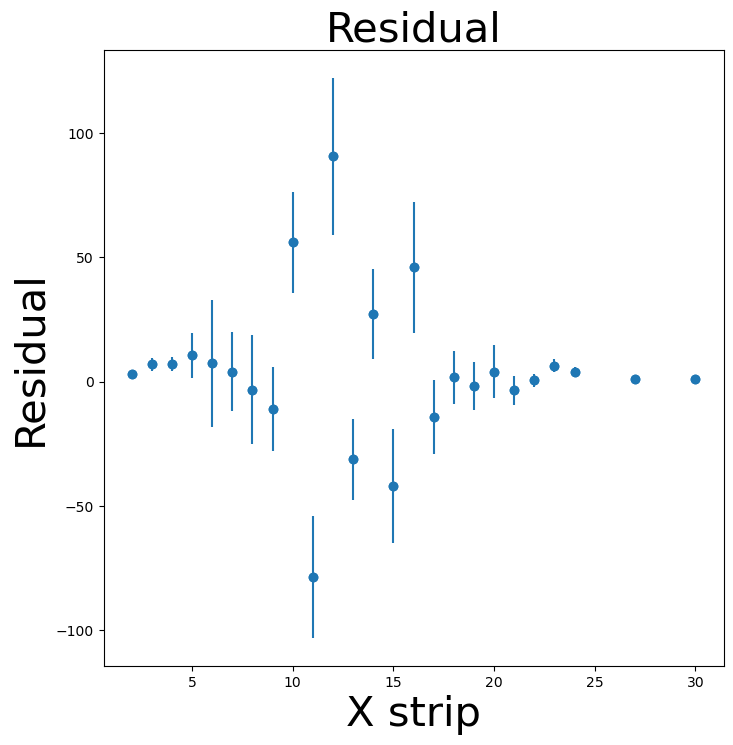

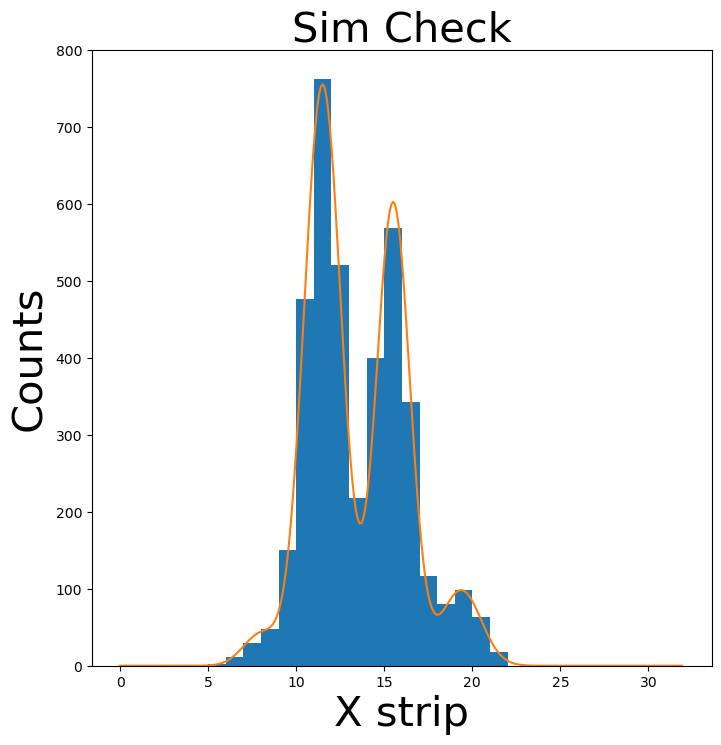

In [5]:
cal = pd.read_csv('run231_calibration_run040.txt', sep = '\t', index_col = 0)

df_1, t1_1 = readDS('run231_040_output.txt', cal)

### Checking Energies
plt.figure(figsize = (8,8))
plt.hist2d(df_1['x'], df_1['xE'], range = ((0,32),(5000,9000)), bins = (32,100), cmap = 'cividis', cmin = 1)
plt.tick_params(axis='both', labelsize=20)
plt.xlabel('X Strip', fontsize= 30)
plt.ylabel('Energy (KeV)',fontsize = 30)
plt.ylim(5000,6800)
plt.axhline(5156, color = "red")
plt.axhline(5200, color = "red")
plt.axhline(5100, color = "red")
plt.axhline(5485, color = "red")
plt.axhline(5530, color = "red")
plt.axhline(5435, color = "red")
plt.axhline(5804, color = "red")
plt.axhline(5850, color = "red")
plt.axhline(5750, color = "red")
plt.title("Energies", fontsize = 30)

### Gating Data and setting up Histograms
gates_1 = df_1[(df_1['y'] >=5) & (df_1['y'] < 19) & (df_1['xE'] > 5900) & (df_1['xE']<6500)]


### POXY
plt.figure(figsize = (8,8))
plt.hist2d(gates_1['x'], gates_1['y'], range = ((0,32),(0,32)), bins = (32,32), cmap = 'cividis', cmin = 1)
plt.xlabel('X', fontsize = 30)
plt.ylabel('Y', fontsize = 30)
plt.title("POXY", fontsize = 30)
plt.show()

### Creating the histogram and fit
xbins = range(0,32)
counts,bins = np.histogram(gates_1['x'],bins = xbins)
bins_=np.arange(0,32,.1)
_bins=np.arange(0,32,1)
newBins_change = _bins[np.where(counts != 0)]
newcounts= counts[np.where(counts!=0)]
ye = np.sqrt(newcounts)
c = cost.LeastSquares(newBins_change,newcounts,ye,fourpeaks)
m= minuit.Minuit(c,40,9,1,760,12.55,1.0915,610,16.57,.9339,100,20.411,1.042)
m.limits = [(0,None),(None,8),(0,1),(0,None), (None,None), (None,1.1), (0,None ), (15.5,15.7), (0, None),(0,None),(19.2,22),(0, 1.2)]
print (m.migrad())
amp_1=m.values[0]
cen_1=m.values[1]
exp_1=m.values[2]
amp_2=m.values[3]
cen_2=m.values[4]
exp_2=m.values[5]
amp_3=m.values[6]
cen_3=m.values[7]
exp_3=m.values[8]
amp_4=m.values[9]
cen_4=m.values[10]
exp_4=m.values[11]
yy= fourpeaks(bins_,amp_1,cen_1,exp_1, amp_2,cen_2,exp_2,amp_3,cen_3,exp_3,amp_4,cen_4,exp_4)
yy_=fourpeaks(newBins_change,amp_1,cen_1,exp_1, amp_2,cen_2,exp_2,amp_3,cen_3,exp_3,amp_4,cen_4,exp_4)
plt.figure(figsize = (8,8))
plt.plot(bins_,yy,linewidth=3)
c_= np.sqrt(newcounts)
error = abs((amp_1+m.errors[0])*(1/((exp_1+m.errors[2])))*(np.exp((-1.0/2.0)*(((newBins_change-cen_1+m.errors[1])/(exp_1+m.errors[2]))**2))) +  (m.errors[3]+amp_2)*(1/((m.errors[5]+exp_2)))*(np.exp((-1.0/2.0)*(((newBins_change-cen_2+m.errors[4])/(m.errors[5]+exp_2))**2)))+ (m.errors[6]+amp_3)*(1/((m.errors[8]+exp_3)))*(np.exp((-1.0/2.0)*(((newBins_change-cen_3+m.errors[7])/(m.errors[8]+exp_3))**2)))+(m.errors[9]+amp_4)*(1/((m.errors[11]+exp_4)))*(np.exp((-1.0/2.0)*(((newBins_change-cen_4+m.errors[10])/(m.errors[11]+exp_4))**2)))-((amp_1)*(1/((exp_1)))*(np.exp((-1.0/2.0)*(((newBins_change-cen_1)/(exp_1))**2))) +  (amp_2)*(1/((exp_2)))*(np.exp((-1.0/2.0)*(((newBins_change-cen_2)/(exp_2))**2)))+ (amp_3)*(1/((exp_3)))*(np.exp((-1.0/2.0)*(((newBins_change-cen_3)/(exp_3))**2)))+(amp_4)*(1/((exp_4)))*(np.exp((-1.0/2.0)*(((newBins_change-cen_4)/(exp_4))**2)))))
reserror= np.sqrt(c_**2+error**2)
plt.hist(gates_1['x'], bins = xbins,align='left')
plt.xlabel('X Strip', fontsize= 30)
plt.ylabel('Counts',fontsize = 30)
plt.title('Histogram+Fit',fontsize = 30)
plt.tick_params(axis='both', labelsize=20)
plt.show()

#### Scatter plot with fit
plt.figure(figsize= (8,8))
plt.plot(bins_,yy)
plt.title("Scatter plot + fit", fontsize= 30)
plt.scatter(newBins_change,newcounts,label='data',color='orange')
plt.errorbar(newBins_change,newcounts,yerr=c_, fmt= "o")
plt.scatter(newBins_change,yy_,label="fit points", color='green')
plt.errorbar(newBins_change,yy_,yerr=error, fmt= 'o')
plt.ylabel("Counts", fontsize = 30)
plt.xlabel("X Strip", fontsize = 30)
legend = plt.legend(loc='upper right', shadow=True, fontsize='x-large')
plt.show()

### Residuals
residual_2lorentz = (newcounts - yy_)
#plt.errorbar(_bins,yy_,yerr=residual_2lorentz, fmt= "o")
#print ( residual_2lorentz)
plt.figure(figsize= (8,8))
plt.title("Residual", fontsize = 30)
plt.scatter(newBins_change,residual_2lorentz)
plt.errorbar(newBins_change,residual_2lorentz, yerr=reserror, fmt= 'o')
plt.xlabel("X strip", fontsize = 30)
plt.ylabel("Residual", fontsize = 30)
plt.show()

### Fit Check/ Sim
area1=amp_1*exp_1/.3989
area2=amp_2*exp_2/.3989
area3=amp_3*exp_3/.3989
area4=amp_4*exp_4/.3989
total= area1+area2+area3+area4

area_1=area1/total
area_2=area2/total
area_3=area3/total
area_4=area4/total


plt.figure(figsize = (8,8))


mu = [cen_1,cen_2,cen_3,cen_4]
sigma = [exp_1,exp_2,exp_3,exp_4]
area = [area_1,area_2,area_3,area_4]
n = sum(counts)
x=[]
for i in range (n):
    hi = (np.argmax(np.random.multinomial(1,area)))
    hii= (np.random.normal(mu[hi], sigma[hi]))
    x.append(hii)


countss_,bins,ignored = plt.hist(x,32,range = (0,32), density=False)
bins_=np.arange(0,32,.1)
plt.plot(bins_,yy)
plt.xlabel("X strip", fontsize = 30)
plt.ylabel("Counts", fontsize = 30)
plt.title("Sim Check", fontsize = 30)
plt.show()



# f044

File: run231_044_output.txt
1 2020-03-26 16:10:14
[' At calibration A/q=202/1']


/var/folders/z5/wjs7x0tx3t777dypj187gf_h0000gn/T/ipykernel_89780/1805324934.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['nX'] = temp.groupby(['t', 'xchan'])['t'].transform('count')
/var/folders/z5/wjs7x0tx3t777dypj187gf_h0000gn/T/ipykernel_89780/1805324934.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['nY'] = temp.groupby(['t', 'ychan'])['t'].transform('count')


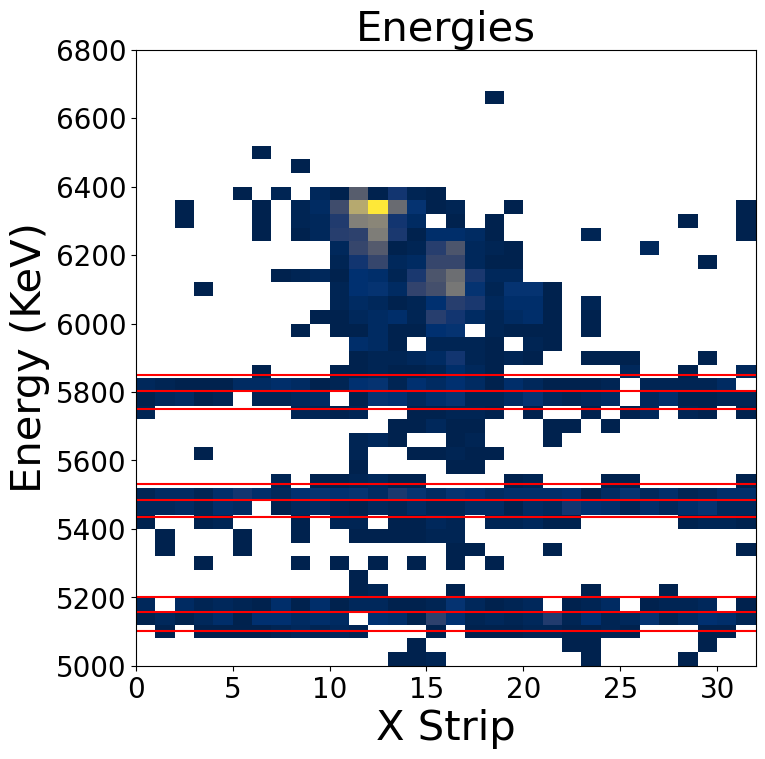

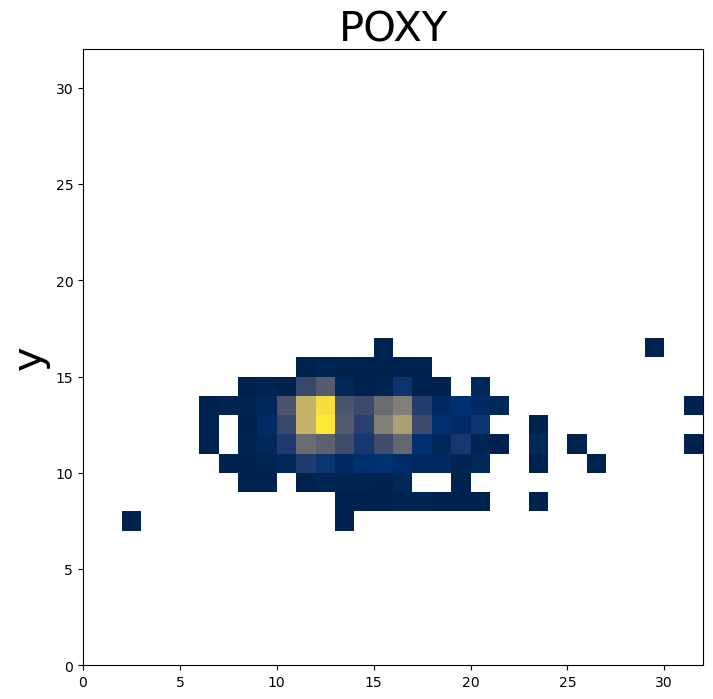

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 19.42 (chi2/ndof = 1.9)    │              Nfcn = 778              │
│ EDM = 4.73e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │       SOME Parameters at limit       │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬────

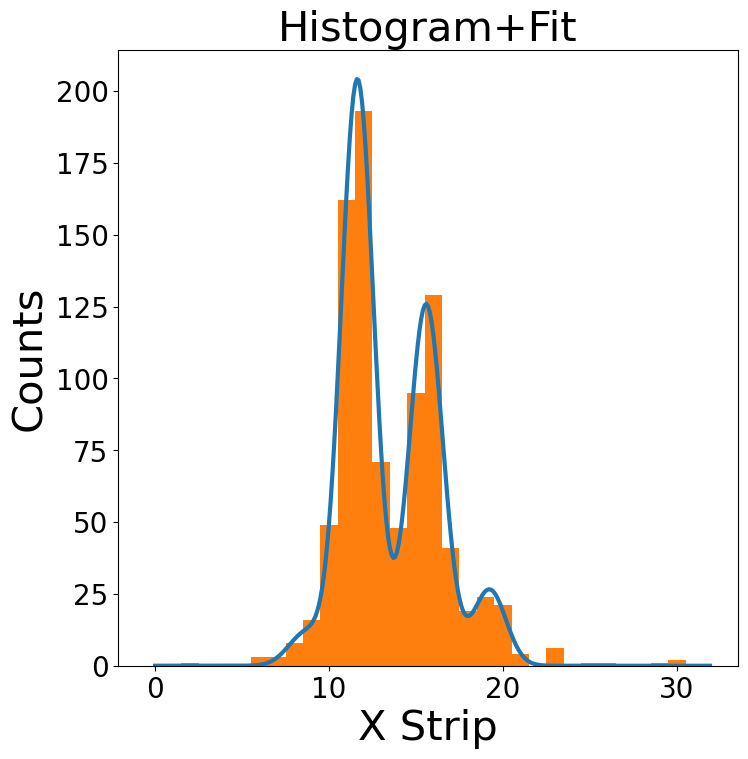

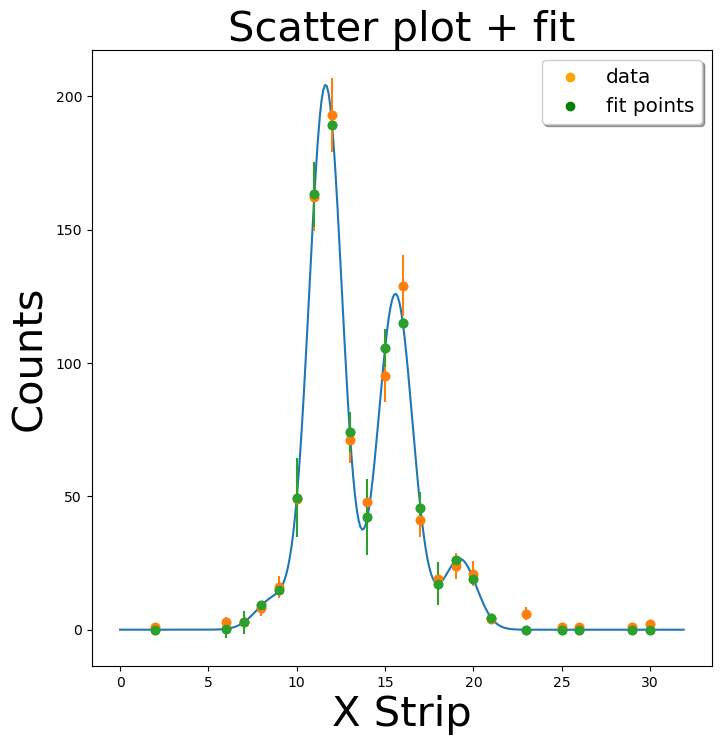

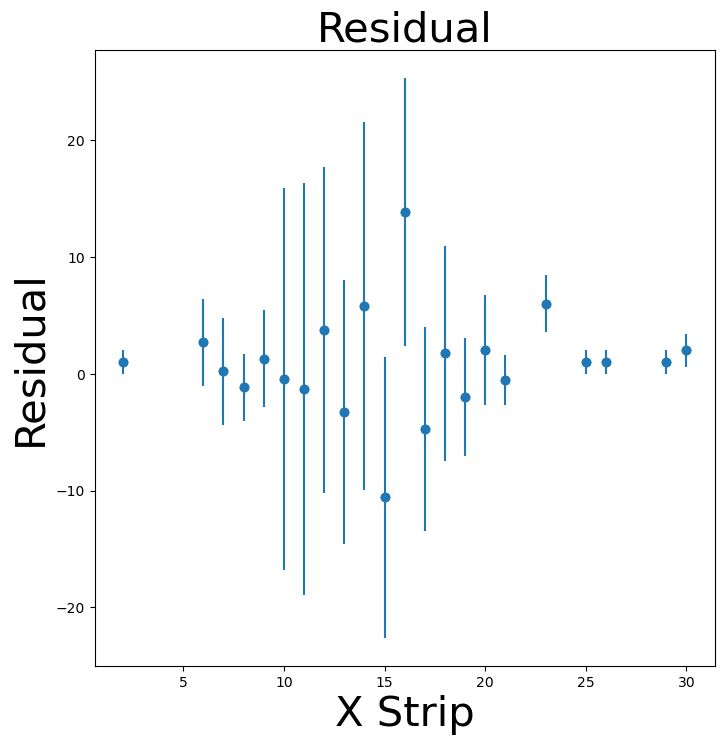

Text(0.5, 1.0, 'Sim Check')

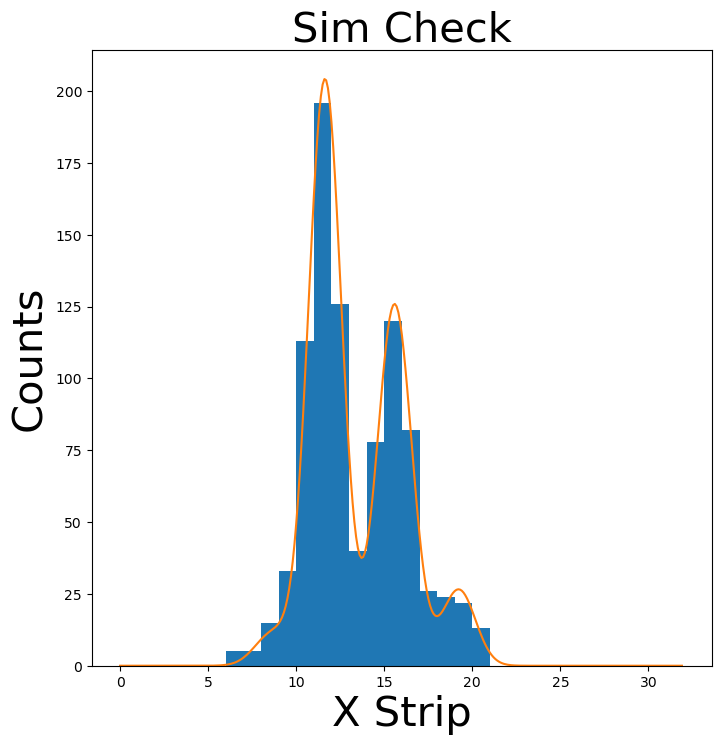

In [6]:
cal = pd.read_csv('run231_calibration_run044.txt', sep = '\t', index_col = 0)

df_2, t1_2 = readDS('run231_044_output.txt', cal)

### Checking Energies
plt.figure(figsize = (8,8))
plt.hist2d(df_2['x'], df_2['xE'], range = ((0,32),(5000,9000)), bins = (32,100), cmap = 'cividis', cmin = 1)
plt.tick_params(axis='both', labelsize=20)
plt.xlabel('X Strip', fontsize= 30)
plt.ylabel('Energy (KeV)',fontsize = 30)
plt.title('Energies',fontsize = 30)
plt.ylim(5000,6800)
plt.axhline(5156, color = "red")
plt.axhline(5200, color = "red")
plt.axhline(5100, color = "red")
plt.axhline(5485, color = "red")
plt.axhline(5530, color = "red")
plt.axhline(5435, color = "red")
plt.axhline(5804, color = "red")
plt.axhline(5850, color = "red")
plt.axhline(5750, color = "red")

### Gating Data and setting up Histograms
gates_2 = df_2[(df_2['y'] >=7) & (df_2['y'] < 17) & (df_2['xE'] > 5900) & (df_2['xE']<6500)]


### POXY
plt.figure(figsize = (8,8))
plt.hist2d(gates_2['x'], gates_2['y'], range = ((0,32),(0,32)), bins = (32,32), cmap = 'cividis', cmin = 1)
plt.ylabel('x',fontsize = 30)
plt.ylabel('y',fontsize = 30)
plt.title('POXY',fontsize = 30)
plt.show()

### Creating the histogram and fit
xbins = range(0,32)
counts,bins = np.histogram(gates_2['x'],bins = xbins)
bins_=np.arange(0,32,.1)
_bins=np.arange(0,32,1)
newBins_change = _bins[np.where(counts != 0)]
newcounts= counts[np.where(counts!=0)]
ye = np.sqrt(newcounts)
c = cost.LeastSquares(newBins_change,newcounts,ye,fourpeaks)
m= minuit.Minuit(c,14.2,9,1,207,12.642,.957,133,16.661,.919,26.3,20.27,.98)
m.limits = [(0,None),(None,10),(0,1),(0,None), (None,None), (None,None), (0,None ), (None,None), (None, None),(0,None),(None,None),(0, None)]
print (m.migrad())
amp_1=m.values[0]
cen_1=m.values[1]
exp_1=m.values[2]
amp_2=m.values[3]
cen_2=m.values[4]
exp_2=m.values[5]
amp_3=m.values[6]
cen_3=m.values[7]
exp_3=m.values[8]
amp_4=m.values[9]
cen_4=m.values[10]
exp_4=m.values[11]
yy= fourpeaks(bins_,amp_1,cen_1,exp_1, amp_2,cen_2,exp_2,amp_3,cen_3,exp_3,amp_4,cen_4,exp_4)
yy_=fourpeaks(newBins_change,amp_1,cen_1,exp_1, amp_2,cen_2,exp_2,amp_3,cen_3,exp_3,amp_4,cen_4,exp_4)
plt.figure(figsize = (8,8))
plt.plot(bins_,yy,linewidth=3)
c_= np.sqrt(newcounts)
error = abs((amp_1+m.errors[0])*(1/((exp_1+m.errors[2])))*(np.exp((-1.0/2.0)*(((newBins_change-cen_1+m.errors[1])/(exp_1+m.errors[2]))**2))) +  (m.errors[3]+amp_2)*(1/((m.errors[5]+exp_2)))*(np.exp((-1.0/2.0)*(((newBins_change-cen_2+m.errors[4])/(m.errors[5]+exp_2))**2)))+ (m.errors[6]+amp_3)*(1/((m.errors[8]+exp_3)))*(np.exp((-1.0/2.0)*(((newBins_change-cen_3+m.errors[7])/(m.errors[8]+exp_3))**2)))+(m.errors[9]+amp_4)*(1/((m.errors[11]+exp_4)))*(np.exp((-1.0/2.0)*(((newBins_change-cen_4+m.errors[10])/(m.errors[11]+exp_4))**2)))-((amp_1)*(1/((exp_1)))*(np.exp((-1.0/2.0)*(((newBins_change-cen_1)/(exp_1))**2))) +  (amp_2)*(1/((exp_2)))*(np.exp((-1.0/2.0)*(((newBins_change-cen_2)/(exp_2))**2)))+ (amp_3)*(1/((exp_3)))*(np.exp((-1.0/2.0)*(((newBins_change-cen_3)/(exp_3))**2)))+(amp_4)*(1/((exp_4)))*(np.exp((-1.0/2.0)*(((newBins_change-cen_4)/(exp_4))**2)))))
reserror= np.sqrt(c_**2+error**2)
plt.hist(gates_2['x'], bins = xbins,align='left')
plt.xlabel('X Strip', fontsize= 30)
plt.ylabel('Counts',fontsize = 30)
plt.title('Histogram+Fit',fontsize = 30)
plt.tick_params(axis='both', labelsize=20)
plt.show()

#### Scatter plot with fit
plt.figure(figsize= (8,8))
plt.plot(bins_,yy)
plt.title("Scatter plot + fit", fontsize= 30)
plt.scatter(newBins_change,newcounts,label='data',color='orange')
plt.errorbar(newBins_change,newcounts,yerr=c_, fmt= "o")
plt.scatter(newBins_change,yy_,label="fit points", color='green')
plt.errorbar(newBins_change,yy_,yerr=error, fmt= 'o')
plt.xlabel('X Strip', fontsize= 30)
legend = plt.legend(loc='upper right', shadow=True, fontsize='x-large')
plt.ylabel('Counts',fontsize = 30)
plt.show()

### Residuals
residual_2lorentz = (newcounts - yy_)
#plt.errorbar(_bins,yy_,yerr=residual_2lorentz, fmt= "o")
#print ( residual_2lorentz)
plt.figure(figsize= (8,8))
plt.title('Residual',fontsize = 30)
plt.scatter(newBins_change,residual_2lorentz)
plt.errorbar(newBins_change,residual_2lorentz, yerr=reserror, fmt= 'o')
plt.xlabel('X Strip', fontsize= 30)
plt.ylabel('Residual',fontsize = 30)
plt.show()

### Fit Check/ Sim
area1=amp_1*exp_1/.3989
area2=amp_2*exp_2/.3989
area3=amp_3*exp_3/.3989
area4=amp_4*exp_4/.3989
total= area1+area2+area3+area4

area_1=area1/total
area_2=area2/total
area_3=area3/total
area_4=area4/total


plt.figure(figsize = (8,8))


mu = [cen_1,cen_2,cen_3,cen_4]
sigma = [exp_1,exp_2,exp_3,exp_4]
area = [area_1,area_2,area_3,area_4]
n = sum(counts)
x=[]
for i in range (n):
    hi = (np.argmax(np.random.multinomial(1,area)))
    hii= (np.random.normal(mu[hi], sigma[hi]))
    x.append(hii)


countss_,bins,ignored = plt.hist(x,32,range = (0,32), density=False)
bins_=np.arange(0,32,.1)
plt.plot(bins_,yy)
plt.xlabel('X Strip',fontsize = 30)
plt.ylabel('Counts',fontsize = 30)
plt.title('Sim Check',fontsize = 30)





# f055

File: run231_055_output.txt
4 2020-03-27 02:49:04
[' scale mpod to 202/1+ ', ' change bgs magnets to At settings', ' do fiona calibration', ' start at 5:07am']


/var/folders/z5/wjs7x0tx3t777dypj187gf_h0000gn/T/ipykernel_89780/1805324934.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['nX'] = temp.groupby(['t', 'xchan'])['t'].transform('count')
/var/folders/z5/wjs7x0tx3t777dypj187gf_h0000gn/T/ipykernel_89780/1805324934.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['nY'] = temp.groupby(['t', 'ychan'])['t'].transform('count')


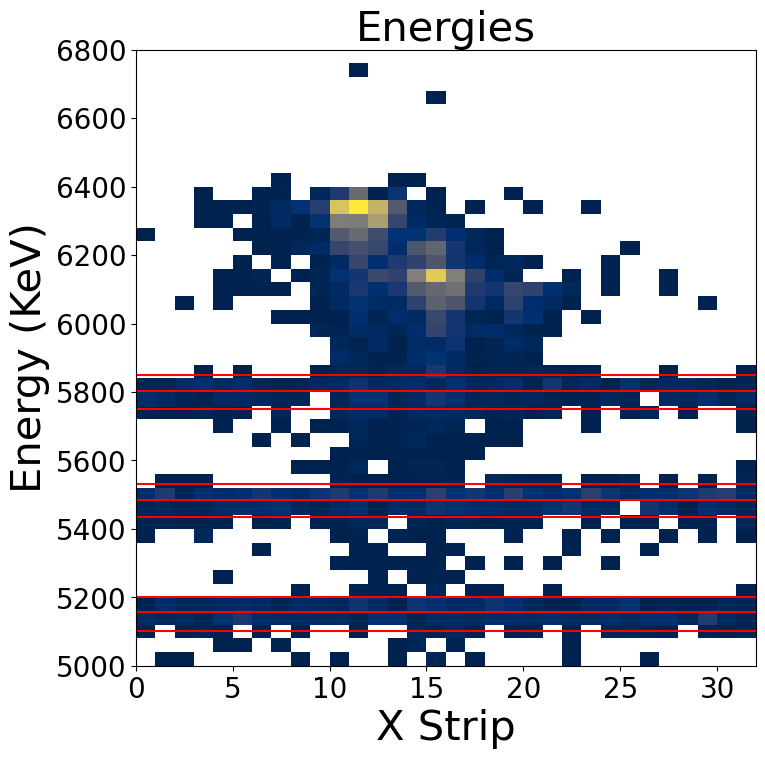

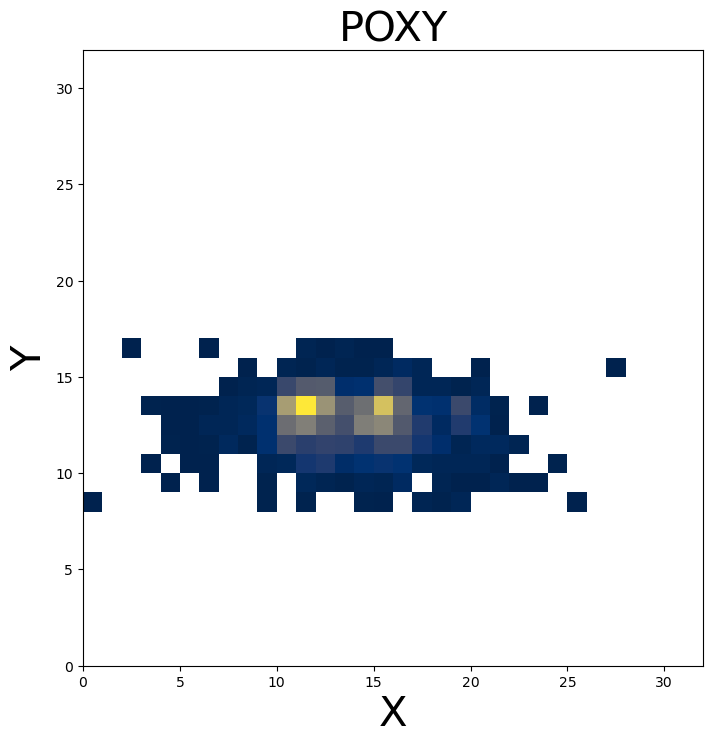

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 21.12 (chi2/ndof = 1.5)    │              Nfcn = 578              │
│ EDM = 7.22e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │       SOME Parameters at limit       │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬────

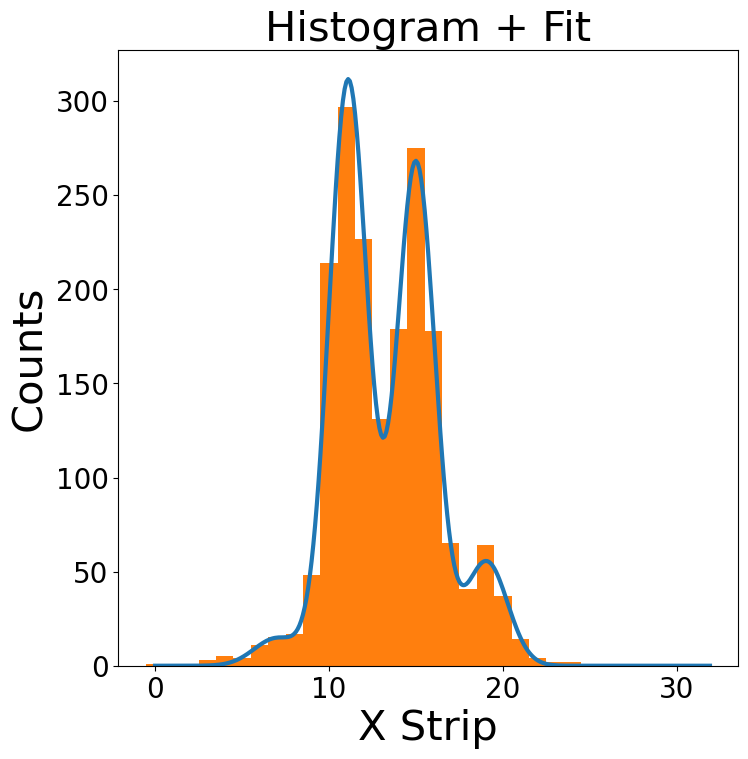

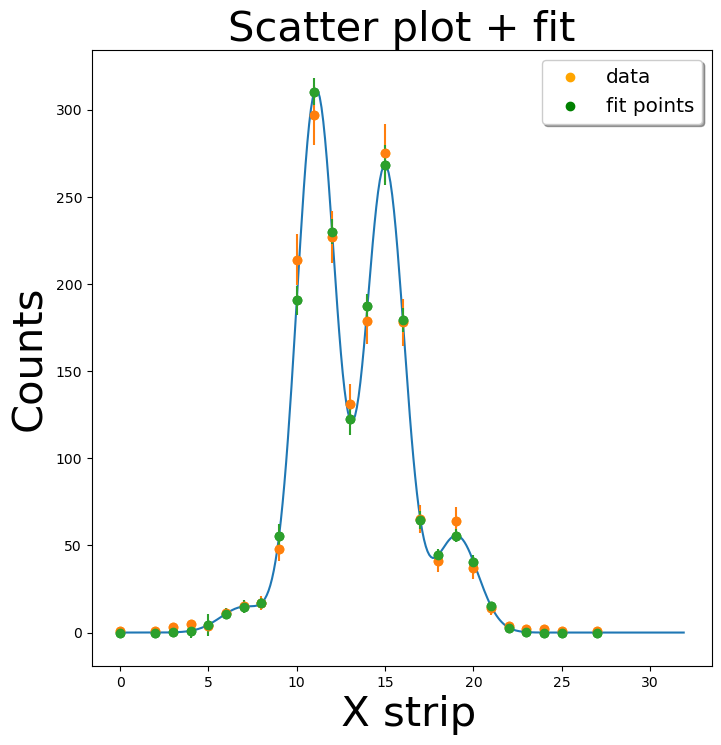

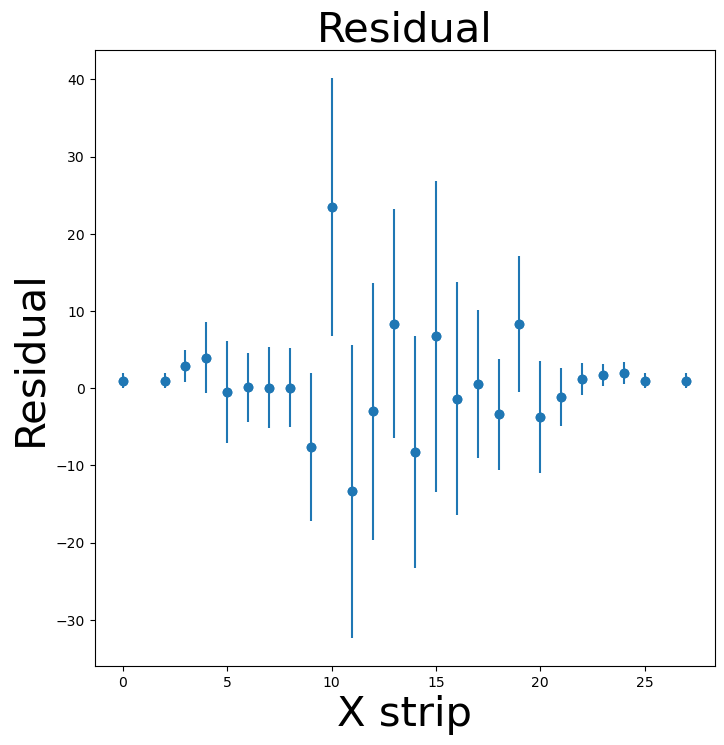

Text(0.5, 1.0, 'Sim Check')

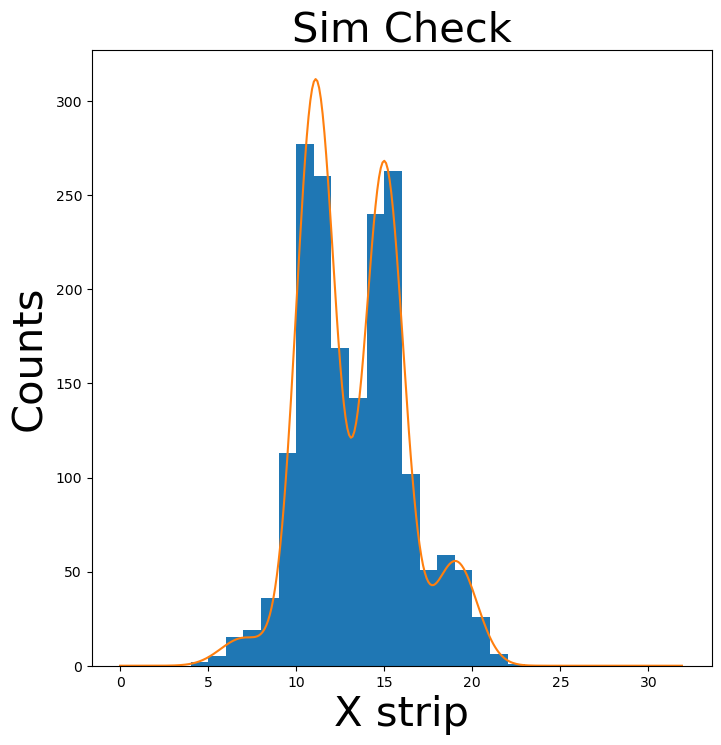

In [7]:
cal = pd.read_csv('run231_calibration_run055.txt', sep = '\t', index_col = 0)

df_3, t1_3 = readDS('run231_055_output.txt', cal)

### Checking Energies
plt.figure(figsize = (8,8))
plt.hist2d(df_3['x'], df_3['xE'], range = ((0,32),(5000,9000)), bins = (32,100), cmap = 'cividis', cmin = 1)
plt.tick_params(axis='both', labelsize=20)
plt.xlabel('X Strip', fontsize= 30)
plt.ylabel('Energy (KeV)',fontsize = 30)
plt.title('Energies',fontsize = 30)
plt.ylim(5000,6800)
plt.axhline(5156, color = "red")
plt.axhline(5200, color = "red")
plt.axhline(5100, color = "red")
plt.axhline(5485, color = "red")
plt.axhline(5530, color = "red")
plt.axhline(5435, color = "red")
plt.axhline(5804, color = "red")
plt.axhline(5850, color = "red")
plt.axhline(5750, color = "red")

### Gating Data and setting up Histograms
gates_3 = df_3[(df_3['y'] >=8) & (df_3['y'] < 17) & (df_3['xE'] > 5900) & (df_3['xE']<6500)]


### POXY
plt.figure(figsize = (8,8))
plt.hist2d(gates_3['x'], gates_3['y'], range = ((0,32),(0,32)), bins = (32,32), cmap = 'cividis', cmin = 1)
plt.xlabel('X',fontsize = 30)
plt.ylabel('Y',fontsize = 30)
plt.title('POXY',fontsize = 30)
plt.show()

### Creating the histogram and fit
xbins = range(0,32)
counts,bins = np.histogram(gates_3['x'],bins = xbins)
bins_=np.arange(0,32,.1)
_bins=np.arange(0,32,1)
newBins_change = _bins[np.where(counts != 0)]
newcounts= counts[np.where(counts!=0)]
ye = np.sqrt(newcounts)
c = cost.LeastSquares(newBins_change,newcounts,ye,fourpeaks)
m= minuit.Minuit(c,13.5,8,1,308,12.063,1.17,269,16.043,1.106,63,20.087,1.106)
m.limits = [(0,None),(None,7),(1,1.3),(0,None), (None,None), (None,None), (0,None), (None,None), (None, None),(0,None),(None,None),(None,None)]
print (m.migrad())
amp_1=m.values[0]
cen_1=m.values[1]
exp_1=m.values[2]
amp_2=m.values[3]
cen_2=m.values[4]
exp_2=m.values[5]
amp_3=m.values[6]
cen_3=m.values[7]
exp_3=m.values[8]
amp_4=m.values[9]
cen_4=m.values[10]
exp_4=m.values[11]
yy= fourpeaks(bins_,amp_1,cen_1,exp_1, amp_2,cen_2,exp_2,amp_3,cen_3,exp_3,amp_4,cen_4,exp_4)
yy_=fourpeaks(newBins_change,amp_1,cen_1,exp_1, amp_2,cen_2,exp_2,amp_3,cen_3,exp_3,amp_4,cen_4,exp_4)
plt.figure(figsize = (8,8))
plt.plot(bins_,yy,linewidth=3)
c_= np.sqrt(newcounts)
error = abs((amp_1+m.errors[0])*(1/((exp_1+m.errors[2])))*(np.exp((-1.0/2.0)*(((newBins_change-cen_1+m.errors[1])/(exp_1+m.errors[2]))**2))) +  (m.errors[3]+amp_2)*(1/((m.errors[5]+exp_2)))*(np.exp((-1.0/2.0)*(((newBins_change-cen_2+m.errors[4])/(m.errors[5]+exp_2))**2)))+ (m.errors[6]+amp_3)*(1/((m.errors[8]+exp_3)))*(np.exp((-1.0/2.0)*(((newBins_change-cen_3+m.errors[7])/(m.errors[8]+exp_3))**2)))+(m.errors[9]+amp_4)*(1/((m.errors[11]+exp_4)))*(np.exp((-1.0/2.0)*(((newBins_change-cen_4+m.errors[10])/(m.errors[11]+exp_4))**2)))-((amp_1)*(1/((exp_1)))*(np.exp((-1.0/2.0)*(((newBins_change-cen_1)/(exp_1))**2))) +  (amp_2)*(1/((exp_2)))*(np.exp((-1.0/2.0)*(((newBins_change-cen_2)/(exp_2))**2)))+ (amp_3)*(1/((exp_3)))*(np.exp((-1.0/2.0)*(((newBins_change-cen_3)/(exp_3))**2)))+(amp_4)*(1/((exp_4)))*(np.exp((-1.0/2.0)*(((newBins_change-cen_4)/(exp_4))**2)))))
reserror= np.sqrt(c_**2+error**2)
plt.hist(gates_3['x'], bins = xbins,align='left')
plt.xlabel('X Strip', fontsize= 30)
plt.ylabel('Counts',fontsize = 30)
plt.title('Histogram + Fit',fontsize = 30)
plt.tick_params(axis='both', labelsize=20)
plt.show()

#### Scatter plot with fit
plt.figure(figsize= (8,8))
plt.plot(bins_,yy)
plt.title("Scatter plot + fit", fontsize = 30)
plt.scatter(newBins_change,newcounts,label='data',color='orange')
plt.errorbar(newBins_change,newcounts,yerr=c_, fmt= "o")
plt.scatter(newBins_change,yy_,label="fit points", color='green')
plt.errorbar(newBins_change,yy_,yerr=error, fmt= 'o')
plt.ylabel("Counts", fontsize = 30)
plt.xlabel(" X strip", fontsize = 30)
legend = plt.legend(loc='upper right', shadow=True, fontsize='x-large')
plt.show()

### Residuals
residual_2lorentz = (newcounts - yy_)
#plt.errorbar(_bins,yy_,yerr=residual_2lorentz, fmt= "o")
#print ( residual_2lorentz)
plt.figure(figsize= (8,8))
plt.title("Residual", fontsize = 30)
plt.scatter(newBins_change,residual_2lorentz)
plt.errorbar(newBins_change,residual_2lorentz, yerr=reserror, fmt= 'o')
plt.xlabel("X strip", fontsize = 30)
plt.ylabel("Residual", fontsize = 30)
plt.show()

### Fit Check/ Sim
area1=amp_1*exp_1/.3989
area2=amp_2*exp_2/.3989
area3=amp_3*exp_3/.3989
area4=amp_4*exp_4/.3989
total= area1+area2+area3+area4

area_1=area1/total
area_2=area2/total
area_3=area3/total
area_4=area4/total


plt.figure(figsize = (8,8))


mu = [cen_1,cen_2,cen_3,cen_4]
sigma = [exp_1,exp_2,exp_3,exp_4]
area = [area_1,area_2,area_3,area_4]
n = sum(counts)
x=[]
for i in range (n):
    hi = (np.argmax(np.random.multinomial(1,area)))
    hii= (np.random.normal(mu[hi], sigma[hi]))
    x.append(hii)


countss_,bins,ignored = plt.hist(x,32,range = (0,32), density=False)
bins_=np.arange(0,32,.1)
plt.plot(bins_,yy)
plt.xlabel("X strip", fontsize = 30)
plt.ylabel("Counts", fontsize = 30)
plt.title("Sim Check", fontsize = 30)



# f075

File: run231_075_output.txt
3 2020-03-28 02:47:04
[' mpod = 202/1+', ' do a fiona calibration with At', ' still have butane in the trap']


/var/folders/z5/wjs7x0tx3t777dypj187gf_h0000gn/T/ipykernel_89780/1805324934.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['nX'] = temp.groupby(['t', 'xchan'])['t'].transform('count')
/var/folders/z5/wjs7x0tx3t777dypj187gf_h0000gn/T/ipykernel_89780/1805324934.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['nY'] = temp.groupby(['t', 'ychan'])['t'].transform('count')


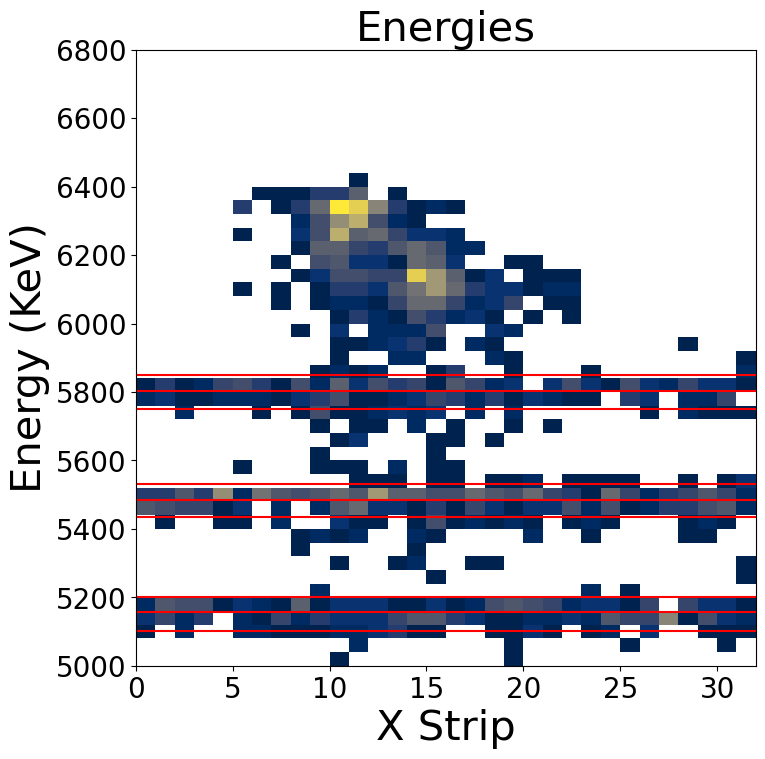

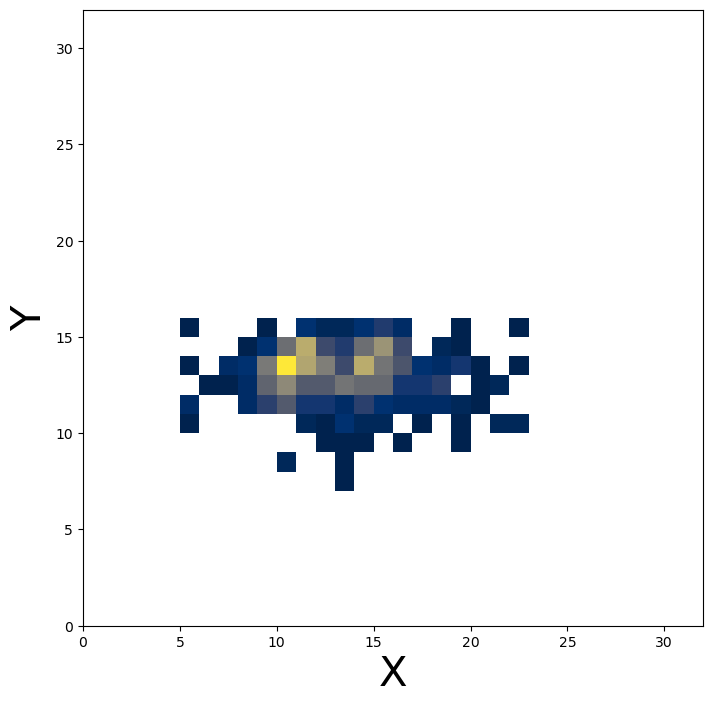

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 12.56 (chi2/ndof = 2.1)    │              Nfcn = 807              │
│ EDM = 0.000166 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │       SOME Parameters at limit       │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬────

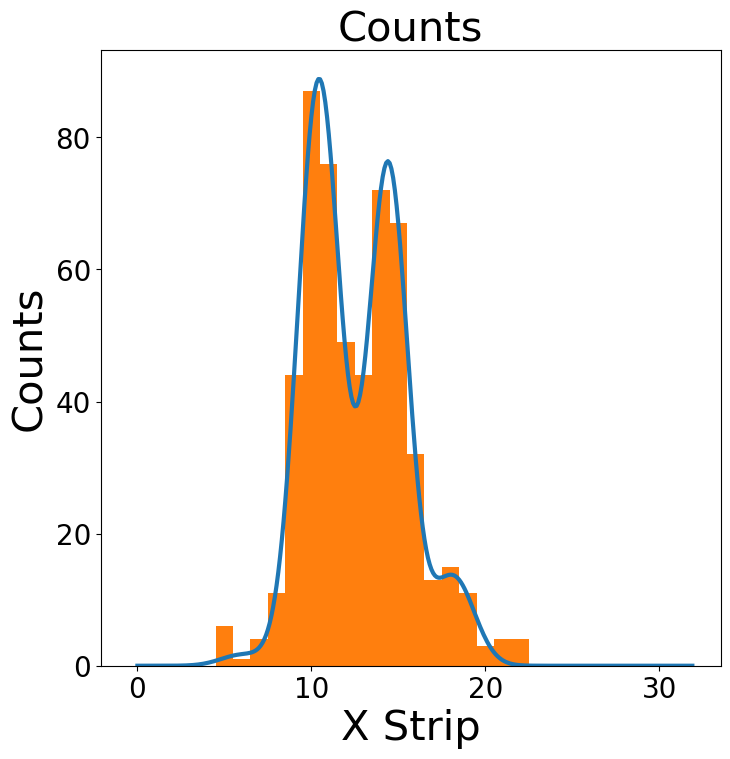

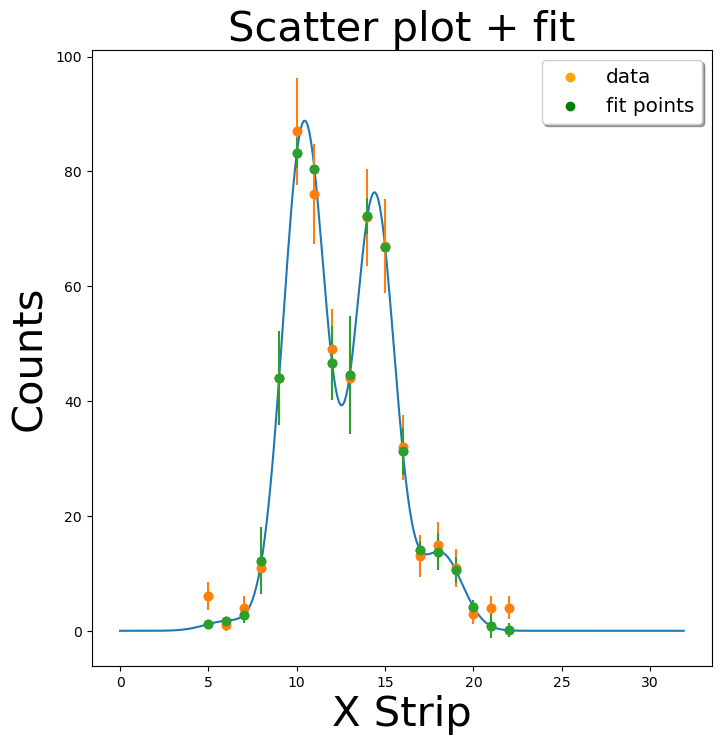

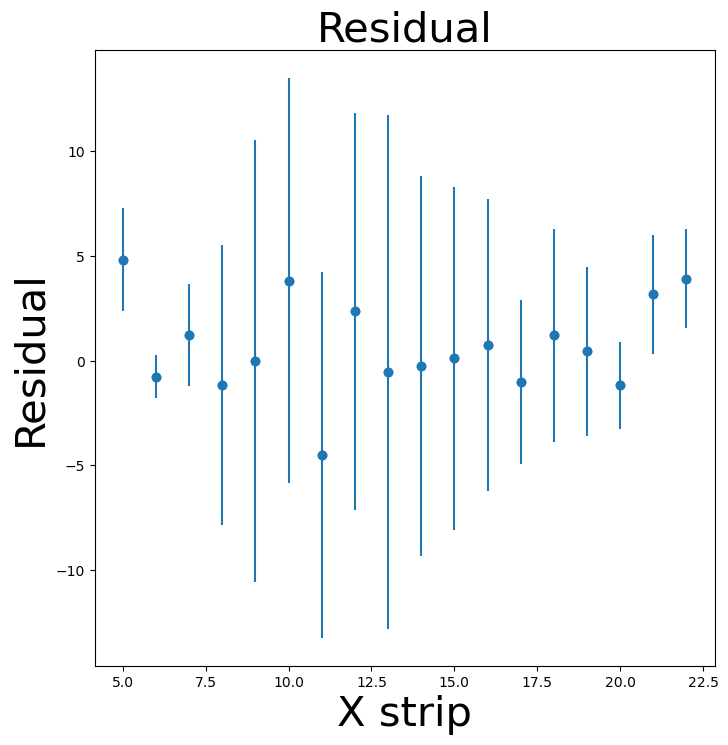

Text(0.5, 1.0, 'Sim Check')

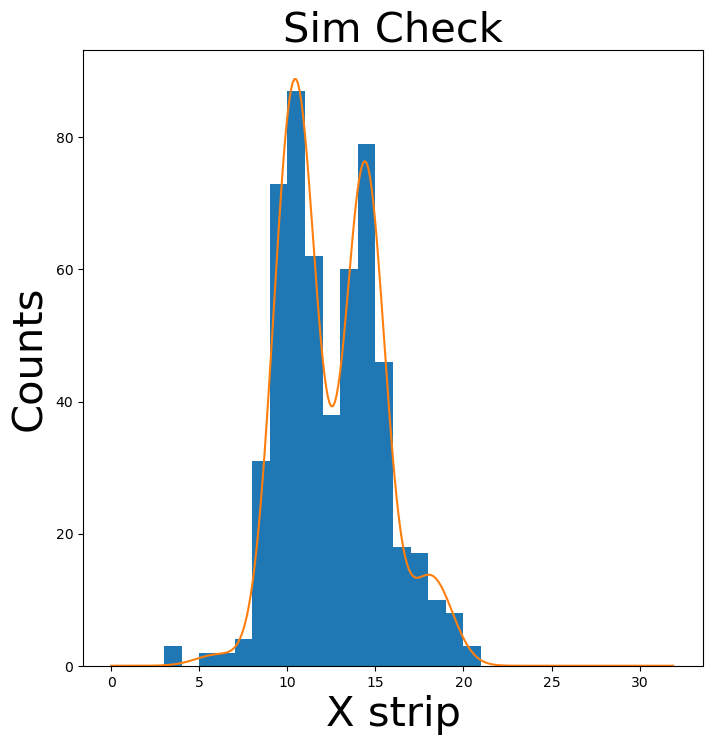

In [8]:
cal = pd.read_csv('run231_calibration_run075.txt', sep = '\t', index_col = 0)

df_4, t1_4 = readDS('run231_075_output.txt', cal)

### Checking Energies
plt.figure(figsize = (8,8))
plt.hist2d(df_4['x'], df_4['xE'], range = ((0,32),(5000,9000)), bins = (32,100), cmap = 'cividis', cmin = 1)
plt.tick_params(axis='both', labelsize=20)
plt.xlabel('X Strip', fontsize= 30)
plt.ylabel('Energy (KeV)',fontsize = 30)
plt.title('Energies',fontsize = 30)
plt.ylim(5000,6800)
plt.axhline(5156, color = "red")
plt.axhline(5200, color = "red")
plt.axhline(5100, color = "red")
plt.axhline(5485, color = "red")
plt.axhline(5530, color = "red")
plt.axhline(5435, color = "red")
plt.axhline(5804, color = "red")
plt.axhline(5850, color = "red")
plt.axhline(5750, color = "red")

### Gating Data and setting up Histograms
gates_4 = df_4[(df_4['y'] >=7) & (df_4['y'] < 16) & (df_4['xE'] > 5900) & (df_4['xE']<6500)]


### POXY
plt.figure(figsize = (8,8))
plt.hist2d(gates_4['x'], gates_4['y'], range = ((0,32),(0,32)), bins = (32,32), cmap = 'cividis', cmin = 1)
plt.xlabel('X', fontsize = 30)
plt.ylabel('Y', fontsize = 30)
plt.show()

### Creating the histogram and fit
xbins = range(0,32)
counts,bins = np.histogram(gates_4['x'],bins = xbins)
bins_=np.arange(0,32,.1)
_bins=np.arange(0,32,1)
newBins_change = _bins[np.where(counts != 0)]
newcounts= counts[np.where(counts!=0)]
ye = np.sqrt(newcounts)
c = cost.LeastSquares(newBins_change,newcounts,ye,fourpeaks)
m= minuit.Minuit(c,2.3,8,1.2,88,11.419,1.201,77,15.394,1.13,14,19.19,1.32)
m.limits = [(0,None),(6,8),(0,1.2),(0,None), (0,None), (None,None), (0,None), (0,None), (None, None),(0,None),(0,None),(0, 1.2)]
print (m.migrad())
amp_1=m.values[0]
cen_1=m.values[1]
exp_1=m.values[2]
amp_2=m.values[3]
cen_2=m.values[4]
exp_2=m.values[5]
amp_3=m.values[6]
cen_3=m.values[7]
exp_3=m.values[8]
amp_4=m.values[9]
cen_4=m.values[10]
exp_4=m.values[11]
yy= fourpeaks(bins_,amp_1,cen_1,exp_1, amp_2,cen_2,exp_2,amp_3,cen_3,exp_3,amp_4,cen_4,exp_4)
yy_=fourpeaks(newBins_change,amp_1,cen_1,exp_1, amp_2,cen_2,exp_2,amp_3,cen_3,exp_3,amp_4,cen_4,exp_4)
plt.figure(figsize = (8,8))
plt.plot(bins_,yy,linewidth=3)
c_= np.sqrt(newcounts)
error = abs((amp_1+m.errors[0])*(1/((exp_1+m.errors[2])))*(np.exp((-1.0/2.0)*(((newBins_change-cen_1+m.errors[1])/(exp_1+m.errors[2]))**2))) +  (m.errors[3]+amp_2)*(1/((m.errors[5]+exp_2)))*(np.exp((-1.0/2.0)*(((newBins_change-cen_2+m.errors[4])/(m.errors[5]+exp_2))**2)))+ (m.errors[6]+amp_3)*(1/((m.errors[8]+exp_3)))*(np.exp((-1.0/2.0)*(((newBins_change-cen_3+m.errors[7])/(m.errors[8]+exp_3))**2)))+(m.errors[9]+amp_4)*(1/((m.errors[11]+exp_4)))*(np.exp((-1.0/2.0)*(((newBins_change-cen_4+m.errors[10])/(m.errors[11]+exp_4))**2)))-((amp_1)*(1/((exp_1)))*(np.exp((-1.0/2.0)*(((newBins_change-cen_1)/(exp_1))**2))) +  (amp_2)*(1/((exp_2)))*(np.exp((-1.0/2.0)*(((newBins_change-cen_2)/(exp_2))**2)))+ (amp_3)*(1/((exp_3)))*(np.exp((-1.0/2.0)*(((newBins_change-cen_3)/(exp_3))**2)))+(amp_4)*(1/((exp_4)))*(np.exp((-1.0/2.0)*(((newBins_change-cen_4)/(exp_4))**2)))))
reserror= np.sqrt(c_**2+error**2)
plt.hist(gates_4['x'], bins = xbins,align='left')
plt.xlabel('X Strip', fontsize= 30)
plt.ylabel('Counts',fontsize = 30)
plt.title('Counts',fontsize = 30)
plt.tick_params(axis='both', labelsize=20)
plt.show()

#### Scatter plot with fit
plt.figure(figsize= (8,8))
plt.plot(bins_,yy)
plt.title("Scatter plot + fit", fontsize = 30)
plt.scatter(newBins_change,newcounts,label='data',color='orange')
plt.errorbar(newBins_change,newcounts,yerr=c_, fmt= "o")
plt.scatter(newBins_change,yy_,label="fit points", color='green')
plt.errorbar(newBins_change,yy_,yerr=error, fmt= 'o')
legend = plt.legend(loc='upper right', shadow=True, fontsize='x-large')
plt.ylabel("Counts", fontsize = 30)
plt.xlabel("X Strip", fontsize = 30)
plt.show()

### Residuals
residual_2lorentz = (newcounts - yy_)
#plt.errorbar(_bins,yy_,yerr=residual_2lorentz, fmt= "o")
#print ( residual_2lorentz)
plt.figure(figsize= (8,8))
plt.title("Residual", fontsize = 30)
plt.scatter(newBins_change,residual_2lorentz)
plt.errorbar(newBins_change,residual_2lorentz, yerr=reserror, fmt= 'o')
plt.xlabel("X strip", fontsize = 30)
plt.ylabel("Residual", fontsize = 30)
plt.show()

### Fit Check/ Sim
area1=amp_1*exp_1/.3989
area2=amp_2*exp_2/.3989
area3=amp_3*exp_3/.3989
area4=amp_4*exp_4/.3989
total= area1+area2+area3+area4

area_1=area1/total
area_2=area2/total
area_3=area3/total
area_4=area4/total


plt.figure(figsize = (8,8))


mu = [cen_1,cen_2,cen_3,cen_4]
sigma = [exp_1,exp_2,exp_3,exp_4]
area = [area_1,area_2,area_3,area_4]
n = sum(counts)
x=[]
for i in range (n):
    hi = (np.argmax(np.random.multinomial(1,area)))
    hii= (np.random.normal(mu[hi], sigma[hi]))
    x.append(hii)


countss_,bins,ignored = plt.hist(x,32,range = (0,32), density=False)
bins_=np.arange(0,32,.1)
plt.plot(bins_,yy)
plt.xlabel("X strip", fontsize = 30)
plt.ylabel("Counts", fontsize = 30)
plt.title("Sim Check", fontsize = 30)



In [46]:
# f082

File: run231_082_output.txt
2 2020-03-28 12:10:17
[' calibration with At+', ' scaled to 202/1']


/var/folders/z5/wjs7x0tx3t777dypj187gf_h0000gn/T/ipykernel_89780/1805324934.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['nX'] = temp.groupby(['t', 'xchan'])['t'].transform('count')
/var/folders/z5/wjs7x0tx3t777dypj187gf_h0000gn/T/ipykernel_89780/1805324934.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['nY'] = temp.groupby(['t', 'ychan'])['t'].transform('count')


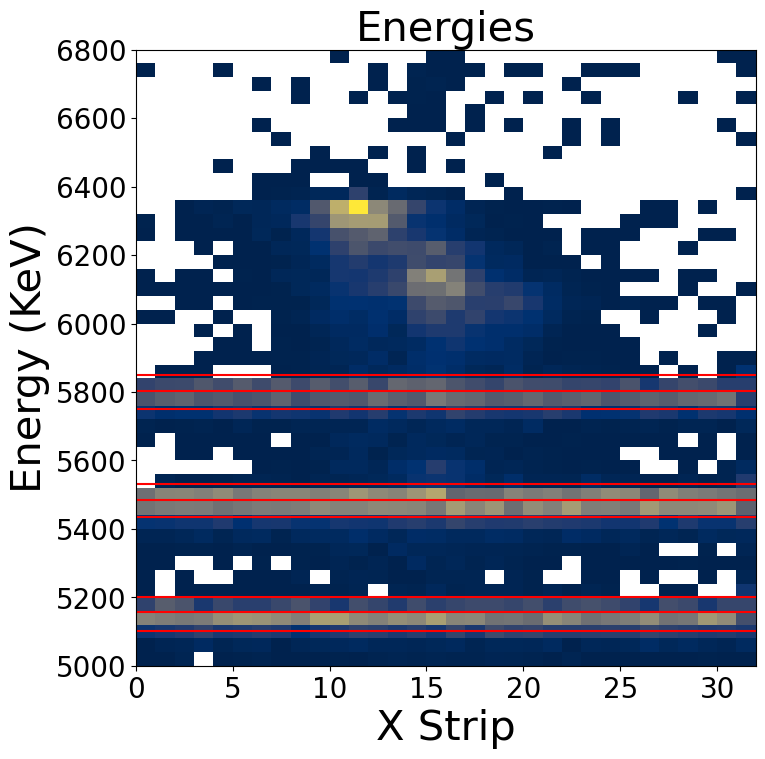

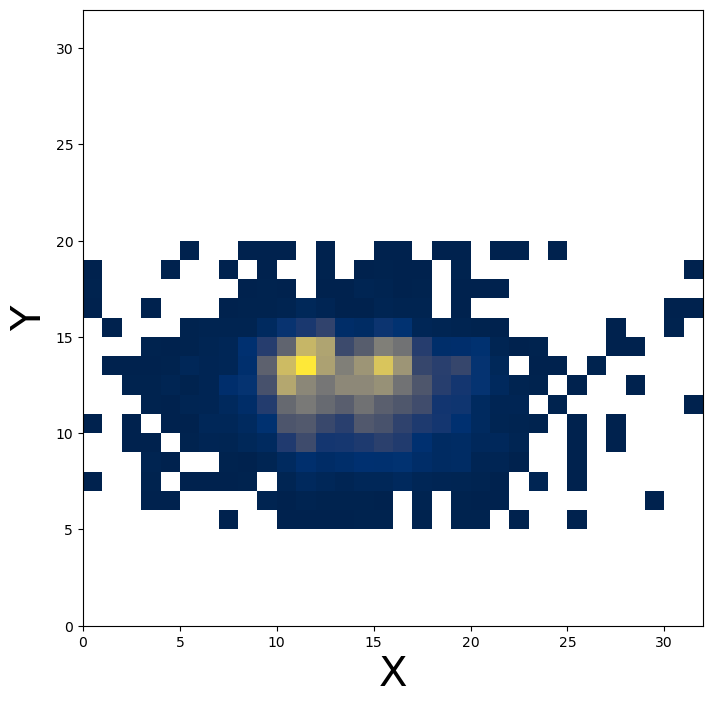

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 74.52 (chi2/ndof = 3.9)    │              Nfcn = 974              │
│ EDM = 5.99e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │       SOME Parameters at limit       │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬────

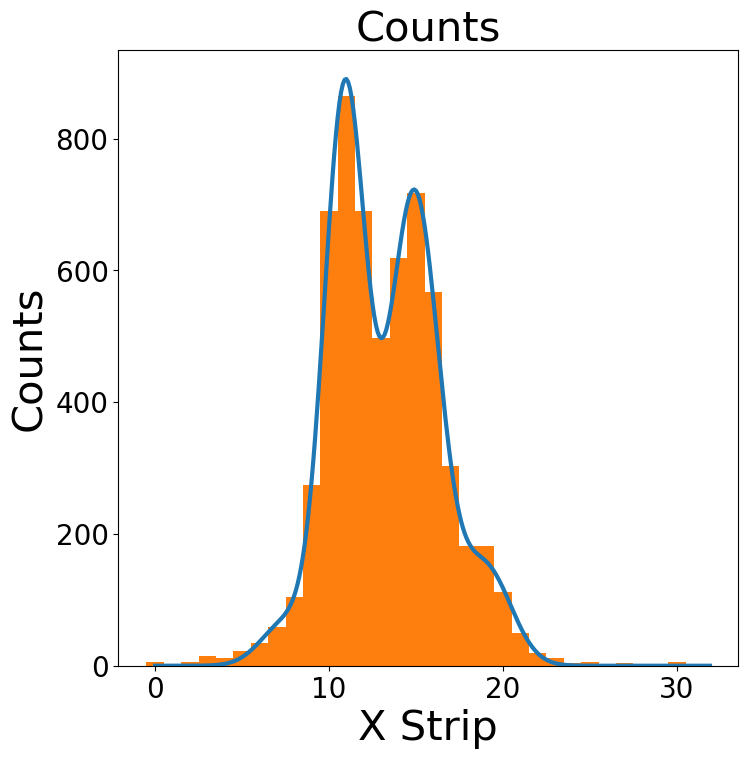

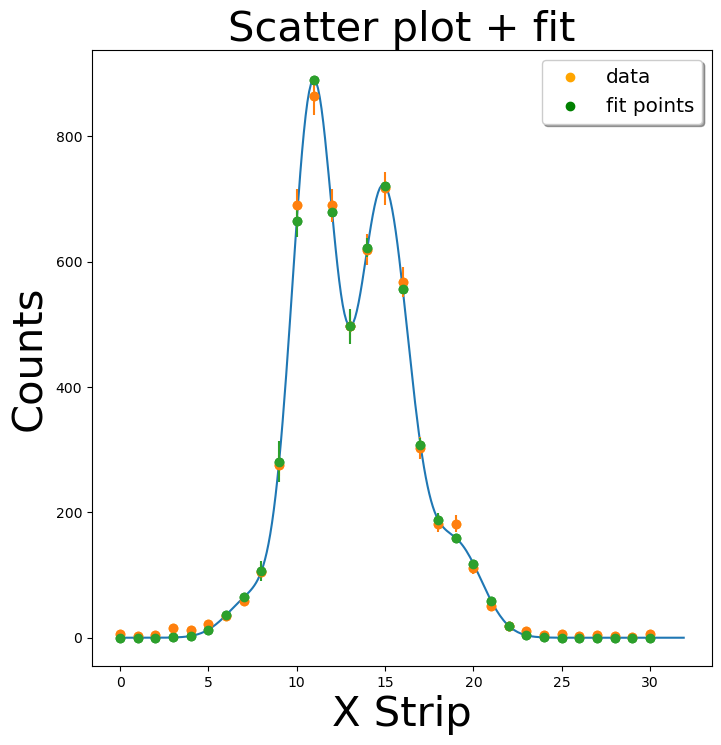

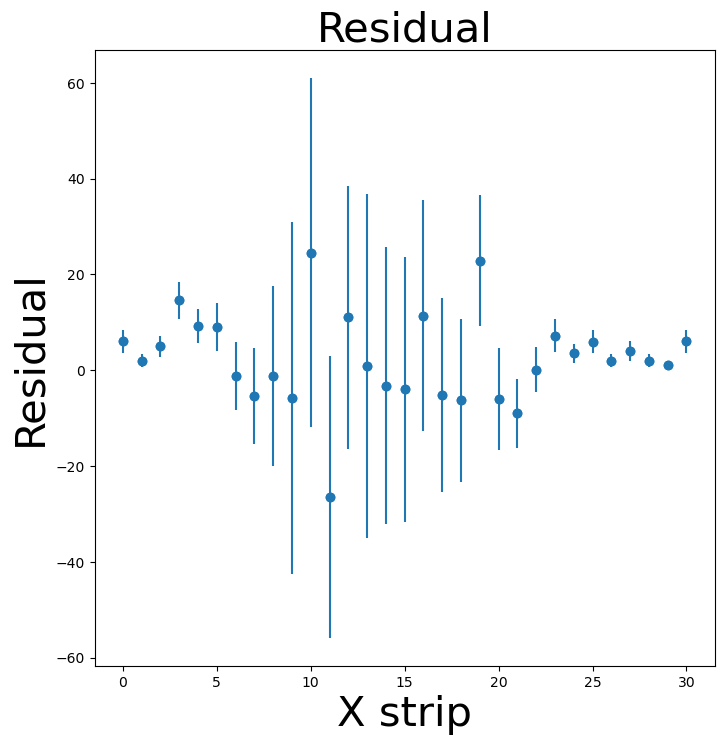

Text(0.5, 1.0, 'Sim Check')

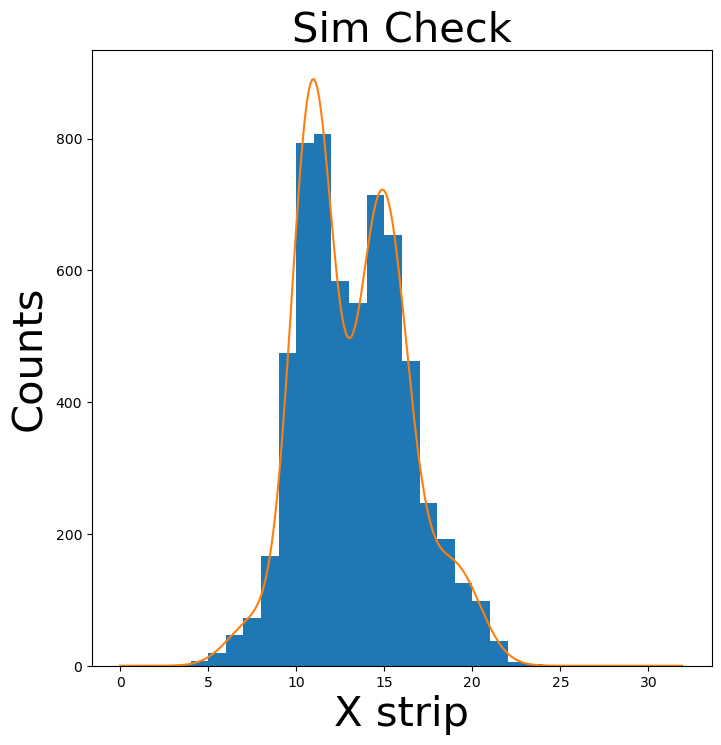

In [9]:
cal = pd.read_csv('run231_calibration_run055.txt', sep = '\t', index_col = 0)

df_5, t1_5 = readDS('run231_082_output.txt', cal)

### Checking Energies
plt.figure(figsize = (8,8))
plt.hist2d(df_5['x'], df_5['xE'], range = ((0,32),(5000,9000)), bins = (32,100), cmap = 'cividis', cmin = 1)
plt.tick_params(axis='both', labelsize=20)
plt.xlabel('X Strip', fontsize= 30)
plt.ylabel('Energy (KeV)',fontsize = 30)
plt.title('Energies',fontsize = 30)
plt.ylim(5000,6800)
plt.axhline(5156, color = "red")
plt.axhline(5200, color = "red")
plt.axhline(5100, color = "red")
plt.axhline(5485, color = "red")
plt.axhline(5530, color = "red")
plt.axhline(5435, color = "red")
plt.axhline(5804, color = "red")
plt.axhline(5850, color = "red")
plt.axhline(5750, color = "red")

### Gating Data and setting up Histograms
gates_5 = df_5[(df_5['y'] >=5) & (df_5['y'] < 20) & (df_5['xE'] > 5900) & (df_5['xE']<6500)]


### POXY
plt.figure(figsize = (8,8))
plt.hist2d(gates_5['x'], gates_5['y'], range = ((0,32),(0,32)), bins = (32,32), cmap = 'cividis', cmin = 1)
plt.xlabel('X', fontsize = 30)
plt.ylabel('Y', fontsize = 30)
plt.show()

### Creating the histogram and fit
xbins = range(0,32)
counts,bins = np.histogram(gates_5['x'],bins = xbins)
bins_=np.arange(0,32,.1)
_bins=np.arange(0,32,1)
newBins_change = _bins[np.where(counts != 0)]
newcounts= counts[np.where(counts!=0)]
ye = np.sqrt(newcounts)
c = cost.LeastSquares(newBins_change,newcounts,ye,fourpeaks)
m= minuit.Minuit(c,110,8.5,1.4,832,11.8948,1.331,790,15.9122,1.527,177,20.145,1.256)
m.limits = [(0,None),(7.5,9),(1,1.4),(0,None), (0,None), (None,None), (0,None), (0,None), (None,None),(0,None),(19,None),(0,1.5)]
print (m.migrad())
amp_1=m.values[0]
cen_1=m.values[1]
exp_1=m.values[2]
amp_2=m.values[3]
cen_2=m.values[4]
exp_2=m.values[5]
amp_3=m.values[6]
cen_3=m.values[7]
exp_3=m.values[8]
amp_4=m.values[9]
cen_4=m.values[10]
exp_4=m.values[11]
yy= fourpeaks(bins_,amp_1,cen_1,exp_1, amp_2,cen_2,exp_2,amp_3,cen_3,exp_3,amp_4,cen_4,exp_4)
yy_=fourpeaks(newBins_change,amp_1,cen_1,exp_1, amp_2,cen_2,exp_2,amp_3,cen_3,exp_3,amp_4,cen_4,exp_4)
plt.figure(figsize = (8,8))
plt.plot(bins_,yy,linewidth=3)
c_= np.sqrt(newcounts)
error = abs((amp_1+m.errors[0])*(1/((exp_1+m.errors[2])))*(np.exp((-1.0/2.0)*(((newBins_change-cen_1+m.errors[1])/(exp_1+m.errors[2]))**2))) +  (m.errors[3]+amp_2)*(1/((m.errors[5]+exp_2)))*(np.exp((-1.0/2.0)*(((newBins_change-cen_2+m.errors[4])/(m.errors[5]+exp_2))**2)))+ (m.errors[6]+amp_3)*(1/((m.errors[8]+exp_3)))*(np.exp((-1.0/2.0)*(((newBins_change-cen_3+m.errors[7])/(m.errors[8]+exp_3))**2)))+(m.errors[9]+amp_4)*(1/((m.errors[11]+exp_4)))*(np.exp((-1.0/2.0)*(((newBins_change-cen_4+m.errors[10])/(m.errors[11]+exp_4))**2)))-((amp_1)*(1/((exp_1)))*(np.exp((-1.0/2.0)*(((newBins_change-cen_1)/(exp_1))**2))) +  (amp_2)*(1/((exp_2)))*(np.exp((-1.0/2.0)*(((newBins_change-cen_2)/(exp_2))**2)))+ (amp_3)*(1/((exp_3)))*(np.exp((-1.0/2.0)*(((newBins_change-cen_3)/(exp_3))**2)))+(amp_4)*(1/((exp_4)))*(np.exp((-1.0/2.0)*(((newBins_change-cen_4)/(exp_4))**2)))))
reserror= np.sqrt(c_**2+error**2)
plt.hist(gates_5['x'], bins = xbins,align='left')
plt.xlabel('X Strip', fontsize= 30)
plt.ylabel('Counts',fontsize = 30)
plt.title('Counts',fontsize = 30)
plt.tick_params(axis='both', labelsize=20)
plt.show()

#### Scatter plot with fit
plt.figure(figsize= (8,8))
plt.plot(bins_,yy)
plt.title("Scatter plot + fit", fontsize = 30)
plt.scatter(newBins_change,newcounts,label='data',color='orange')
plt.errorbar(newBins_change,newcounts,yerr=c_, fmt= "o")
plt.scatter(newBins_change,yy_,label="fit points", color='green')
plt.errorbar(newBins_change,yy_,yerr=error, fmt= 'o')
plt.ylabel("Counts", fontsize = 30)
plt.xlabel("X Strip", fontsize = 30)
legend = plt.legend(loc='upper right', shadow=True, fontsize='x-large')
plt.show()

### Residuals
residual_2lorentz = (newcounts - yy_)
#plt.errorbar(_bins,yy_,yerr=residual_2lorentz, fmt= "o")
#print ( residual_2lorentz)
plt.figure(figsize= (8,8))
plt.title("Residual", fontsize = 30)
plt.scatter(newBins_change,residual_2lorentz)
plt.errorbar(newBins_change,residual_2lorentz, yerr=reserror, fmt= 'o')
plt.xlabel("X strip", fontsize = 30)
plt.ylabel("Residual", fontsize = 30)
plt.show()

### Fit Check/ Sim
area1=amp_1*exp_1/.3989
area2=amp_2*exp_2/.3989
area3=amp_3*exp_3/.3989
area4=amp_4*exp_4/.3989
total= area1+area2+area3+area4

area_1=area1/total
area_2=area2/total
area_3=area3/total
area_4=area4/total


plt.figure(figsize = (8,8))


mu = [cen_1,cen_2,cen_3,cen_4]
sigma = [exp_1,exp_2,exp_3,exp_4]
area = [area_1,area_2,area_3,area_4]
n = sum(counts)
x=[]
for i in range (n):
    hi = (np.argmax(np.random.multinomial(1,area)))
    hii= (np.random.normal(mu[hi], sigma[hi]))
    x.append(hii)


countss_,bins,ignored = plt.hist(x,32,range = (0,32), density=False)
bins_=np.arange(0,32,.1)
plt.plot(bins_,yy)
plt.xlabel("X strip", fontsize = 30)
plt.ylabel("Counts", fontsize = 30)
plt.title("Sim Check", fontsize = 30)

